# Brief

Implement a Time Series Forecasting model in Python, by using the FBProphet module.
The forecasting model should be able to predict the Sunspots (see below) by using Facebook’s Prophet Time Series Forecasting model. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, daily seasonality.
Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.
Source: https://en.wikipedia.org/wiki/Sunspot
You should test your forecasting model in three (3) distinct datasets. On Daily, Monthly Mean, and Yearly Mean sunspots.

# Imports

In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# quick fixes
%load_ext autoreload
import matplotlib.font_manager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

### Data loading and processing 

In [224]:
# get datetime and move to first
def make_col_datetime(df, freq):
    
    # get datetime features present
    date_features_array = ['Year', 'Month', 'Day']
    for feature in date_features_array:
        if(feature not in df.columns):
            if(feature == 'Day'):
                df.insert(2, feature, 1)
            if(feature == 'Month'):
                df.insert(1, feature, 1)
    
    #make datetime 
    df['Date'] = pd.to_datetime(df[date_features_array])
    df['ds'] = pd.to_datetime(df[date_features_array])
    
    # pop the column 
    first_column = df.pop('Date')

    # insert at first position 
    df.insert(0, 'Date', first_column)
    
    # Set as index
    df = df.set_index('Date')

    # Convert TimeSeries to specified frequency
    df = df.asfreq(freq)

    # sort
    df = df.sort_index()

    return df

In [235]:
# load data
def data_load(name, col_names, freq):
    df = pd.read_csv(r'data/{}.csv'.format(name), names=col_names, header=None, delimiter=';')
    
    df['Year'] = df['Year'].astype(int)
    return make_col_datetime(df, freq)

In [172]:
def quick_look(df):
    display(df.head(5))
    display(df.tail(5))
    display(df.info())
    display(df.describe())

In [173]:
# may want to explore but focuus in on spots and thhey are well represented in whole dataset 
def df_col_value_gt_or_eq(df, col, value):
    df = df[df[col] >= value]
    return df

In [174]:
def handle_missing(df):
    # replace -1 with None 
    df = df.replace(-1, None)
    
    # creating series True or False for NaN data and present data respectively. 
    nul_data = pd.isnull(df['y']) 

    # print only the data, Customers = NaN 
    display(df[nul_data])
    
    # fill the missing data using the of the present observations
    df = df.assign(y = df.y.fillna(df.y.median()))
    
    # creating series True or False for NaN data and present data respectively. 
    nul_data = pd.isnull(df['y']) 

    # print only the data, Customers = NaN 
    display(df[nul_data])
    
    return df

### Plots

In [175]:
def simple_plot(df, y):
    font = {'family' : 'Lucida Grande',
            'weight' : 'normal',
            'size'   : 16}
    
    fig, ax = plt.subplots(figsize = (14, 10))
    
    df[y].plot(ax = ax, label = y)
    
    plt.title("{} vs Index(Date)".format(y.capitalize()), 
              fontsize = 22)
    
    matplotlib.rc('font', **font)
    
    ax.legend();

In [176]:
def simple_plot_bulk(df, *argv):
    for arg in argv:
        simple_plot(df, arg)

In [177]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [178]:
def plot_kde(labels, *argv):    
    plt.figure(figsize=(14, 11))
    sns.set(font_scale = 2)
    for idx, arg in enumerate(argv):
        sns.kdeplot(arg, label=labels[idx])
    plt.legend(prop={'size': 16})

### Models 

#### Preprocess 

In [179]:
def extract_df(df, feature, name, ds):
    df = df[[ds, feature]]
    df = df.rename(columns={feature: name})
    return df

In [180]:
# Augmented Dickey-Fuller (ADF) Test
# reference: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

# A key point to remember here is: Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value 
# obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring 
# that the series is stationary.

# Load Statsmodels 
import statsmodels.api as sm

# ADF Test
# Function to print out results in customised manner
from statsmodels.tsa.stattools import adfuller

# ADF
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print (dfoutput)
    
    print("Conclusion")
    print(dftest[1])
    if(dftest[1] > 0.05):
        print("DO NOT reject the null hypothesis: Non-Stationary")
    else:
        print("Reject the null hypothesis: Stationary")

# Plot and call ADF
def adf_test_show(df, feature):
    # Plotting the Data

    # Define the plot size
    plt.figure(figsize=(16,5))

    # Plot the data
    plt.plot(df.index, df[feature], label = "Sunspot_number")
    plt.legend(loc = 'best')
    plt.title("Sunspot Data")
    plt.show()
    
    adf_test(df[feature])
    

In [181]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

# A key difference from ADF test is the null hypothesis of the KPSS test is that the series is stationary.
# That is, if p-value is < significance level (say 0.05), then the series is non-stationary. Whereas in ADF test, 
# it would mean the tested series is stationary.

# Function to print out results in customised manner
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
    print("Conclusion")
    print(kpsstest[1])
    if(kpsstest[1] < 0.05):
        print("Reject the null hypothesis: Non-Stationary")
    else:
        print("DO NOT Reject the null hypothesis: Stationary")
    


In [182]:
def simple_prophet_model(m, df, period_1, period_2, period_3, freq, daily = False, monthly = False):
    
    m
    # instantiate
    m = Prophet(seasonality_mode='multiplicative',
                               seasonality_prior_scale = 20,
                               daily_seasonality=False, 
                               weekly_seasonality=False,
                               yearly_seasonality=False,
                              )


    # add custom seasonality
    m.add_seasonality(name='yearly',
                                     period=365.25,
                                     fourier_order=25)
    
    if(monthly):
        m.add_seasonality(name='monthly',
                                         period=30.5,
                                         fourier_order=55)
    if(daily):
        m.add_seasonality(name='daily',
                                         period=1,
                                         fourier_order=15)
        
    m.add_seasonality(name='11_yearly',
                                     period=4026,
                                     fourier_order=25)

    # fit
    m.fit(df)

    # future dates & forcast & results
    future_dates_1 = m.make_future_dataframe(periods = period_1, freq = freq)
    forcast_1 = m.predict(future_dates_1)
    display(forcast_1.tail())
    fig_1 = m.plot(forcast_1, uncertainty=True)
    # Visualize Each Component (Trend, Seasonality, ...)
    fig_1_1 = m.plot_components(forcast_1)
    ax_1 = fig_1_1.gca()
    ax_1.tick_params(axis="x", labelsize=12)
    ax_1.tick_params(axis="y", labelsize=12)


    future_dates_2 = m.make_future_dataframe(periods = period_2, freq = freq)
    forcast_2 = m.predict(future_dates_2)
    display(forcast_2.tail())
    fig_2 = m.plot(forcast_2, uncertainty=True)
    # Visualize Each Component (Trend, Seasonality, ...)
    fig_2_1 = m.plot_components(forcast_2)
    ax_2 = fig_2_1.gca()
    ax_2.tick_params(axis="x", labelsize=12)
    ax_2.tick_params(axis="y", labelsize=12)

    future_dates_3 = m.make_future_dataframe(periods = period_3, freq = freq)
    forcast_3 = m.predict(future_dates_3)
    display(forcast_3.tail())
    fig_3 = m.plot(forcast_3, uncertainty=True)
    # Visualize Each Component (Trend, Seasonality, ...)  
    fig_3_1 = m.plot_components(forcast_3)
    ax_3 = fig_3_1.gca()
    ax_3.tick_params(axis="x", labelsize=12)
    ax_3.tick_params(axis="y", labelsize=12)
    
    return m, future_dates_1, forcast_1, future_dates_2, forcast_2, future_dates_3, forcast_3


In [183]:
def split(data, steps):
    data_train = data[:-steps]
    data_test  = data[-steps:]

    print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
    print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
    
    return data_train, data_test

In [184]:
def plot_test_predict(test, forecast):
    ax = forecast.plot(x = 'ds', y = 'yhat', legend = True, label = 'predictions', figsize = (12,8))
    test.plot(x='ds', y = 'y', legend = True, label = 'True Test Data', ax = ax)

In [185]:
def get_performance_metrics_plot(cv):
    df_pm = performance_metrics(cv)
    df_pm.head()
    
    plot_cross_validation_metric(cv, metric='rmse')
    
    plot_cross_validation_metric(cv, metric='mae')
    
    

In [207]:
def model_with_cv(df, growth, n_changepoints, changepoint_prior_scale, seasonality_prior_scale, freq, 
                  periods, initial, period, horizon, units, monthly=True, daily=False):
    
    # cap
    if(growth == 'logistic'):
        df.loc[:,'cap'] = 500
        df.loc[:,'floor'] = 1
        
    
    # instantiate prophet
    prophet_with_cv = Prophet(growth = growth,
                              n_changepoints = n_changepoints,
                              changepoint_prior_scale = changepoint_prior_scale,
                              seasonality_prior_scale = seasonality_prior_scale, 
                              daily_seasonality=False,
                              weekly_seasonality=False,
                              yearly_seasonality=False)
    
    # add custom seasonality
    prophet_with_cv.add_seasonality(name='yearly',
                                     period=365.25,
                                     fourier_order=25)
    
    if(monthly):
        prophet_with_cv.add_seasonality(name='monthly',
                                         period=30.5,
                                         fourier_order=55)
    if(daily):
        prophet_with_cv.add_seasonality(name='daily',
                                         period=1,
                                         fourier_order=15)
        
    prophet_with_cv.add_seasonality(name='11_yearly',
                                     period=4026,
                                     fourier_order=25)
    
    prophet_with_cv.fit(df)
    
    # future 
    future = prophet_with_cv.make_future_dataframe(freq = freq, periods = periods)
    
    # cap
    if(growth == 'logistic'):
        future.loc[:,'cap'] = 500
        future.loc[:,'floor'] = 1
    
    # predict 
    forcast = prophet_with_cv.predict(future)
    
    # predict cv
    cv_results = cross_validation(prophet_with_cv, 
                                  initial='{} {}'.format(initial, units), 
                                  period='{} {}'.format(period, units), 
                                  horizon = '{} {}'.format(horizon, units)
                                 )

    
    return prophet_with_cv, forcast, cv_results

# Daily

## Data and brief EDA

### Load

Year  Month  Day  Decimal_year  Sunspot_number  \
Date                                                         
1818-01-01  1818      1    1      1818.001              -1   
1818-01-02  1818      1    2      1818.004              -1   
1818-01-03  1818      1    3      1818.007              -1   
1818-01-04  1818      1    4      1818.010              -1   
1818-01-05  1818      1    5      1818.012              -1   

            Standard_deviation  Number_observations  Provisional_indicator  \
Date                                                                         
1818-01-01                -1.0                    0                      1   
1818-01-02                -1.0                    0                      1   
1818-01-03                -1.0                    0                      1   
1818-01-04                -1.0                    0                      1   
1818-01-05                -1.0                    0                      1   

                   ds  
Date                   
1818-01-01 1818-01-01  
1818-01-02 1818-01-02  
1818-01-03 1818-01-03  
1818-01-04 1818-01-04  
1818-01-05 1818-01-05

Year  Month  Day  Decimal_year  Sunspot_number  \
Date                                                         
2022-04-26  2022      4   26      2022.316             132   
2022-04-27  2022      4   27      2022.319             132   
2022-04-28  2022      4   28      2022.322             135   
2022-04-29  2022      4   29      2022.325             107   
2022-04-30  2022      4   30      2022.327              51   

            Standard_deviation  Number_observations  Provisional_indicator  \
Date                                                                         
2022-04-26                21.8                   43                      0   
2022-04-27                14.8                   43                      0   
2022-04-28                15.5                   42                      0   
2022-04-29                21.4                   39                      0   
2022-04-30                 8.3                   35                      0   

                   ds  
Date                   
2022-04-26 2022-04-26  
2022-04-27 2022-04-27  
2022-04-28 2022-04-28  
2022-04-29 2022-04-29  
2022-04-30 2022-04-30

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74630 entries, 1818-01-01 to 2022-04-30
Freq: D
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Year                   74630 non-null  int64         
 1   Month                  74630 non-null  int64         
 2   Day                    74630 non-null  int64         
 3   Decimal_year           74630 non-null  float64       
 4   Sunspot_number         74630 non-null  int64         
 5   Standard_deviation     74630 non-null  float64       
 6   Number_observations    74630 non-null  int64         
 7   Provisional_indicator  74630 non-null  int64         
 8   ds                     74630 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 5.7 MB


None

Year         Month           Day  Decimal_year  Sunspot_number  \
count  74630.000000  74630.000000  74630.000000  74630.000000    74630.000000   
mean    1919.665416      6.516522     15.729130   1920.164876       78.580142   
std       58.985539      3.449999      8.799916     58.985309       77.303259   
min     1818.000000      1.000000      1.000000   1818.001000       -1.000000   
25%     1869.000000      4.000000      8.000000   1869.081750       15.000000   
50%     1920.000000      7.000000     16.000000   1920.166500       57.000000   
75%     1971.000000     10.000000     23.000000   1971.247250      123.000000   
max     2022.000000     12.000000     31.000000   2022.327000      528.000000   

       Standard_deviation  Number_observations  Provisional_indicator  
count        74630.000000         74630.000000           74630.000000  
mean             6.905413             4.867279               0.998392  
std              4.792459             8.838895               0.040067  
min             -1.000000             0.000000               0.000000  
25%              2.900000             1.000000               1.000000  
50%              6.500000             1.000000               1.000000  
75%             10.000000             1.000000               1.000000  
max             77.700000            69.000000               1.000000

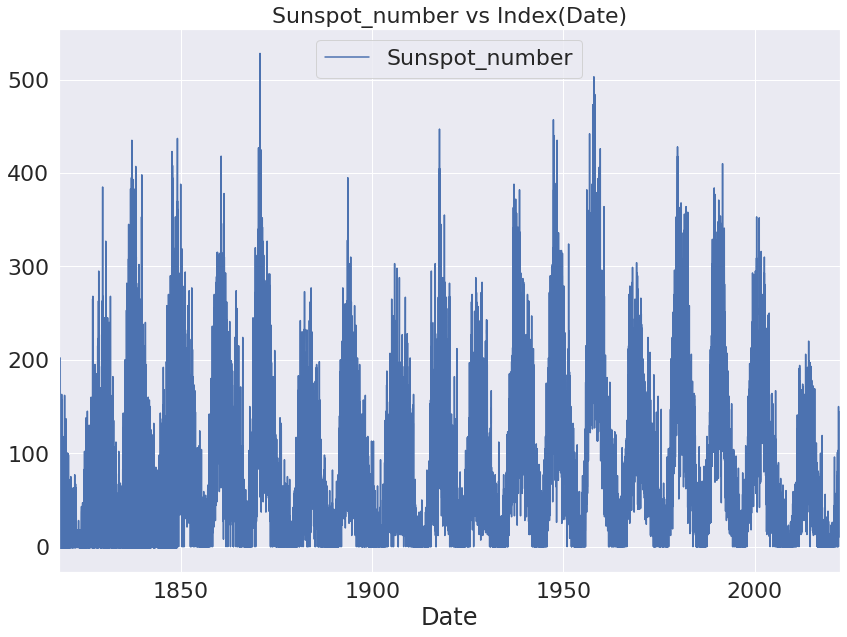

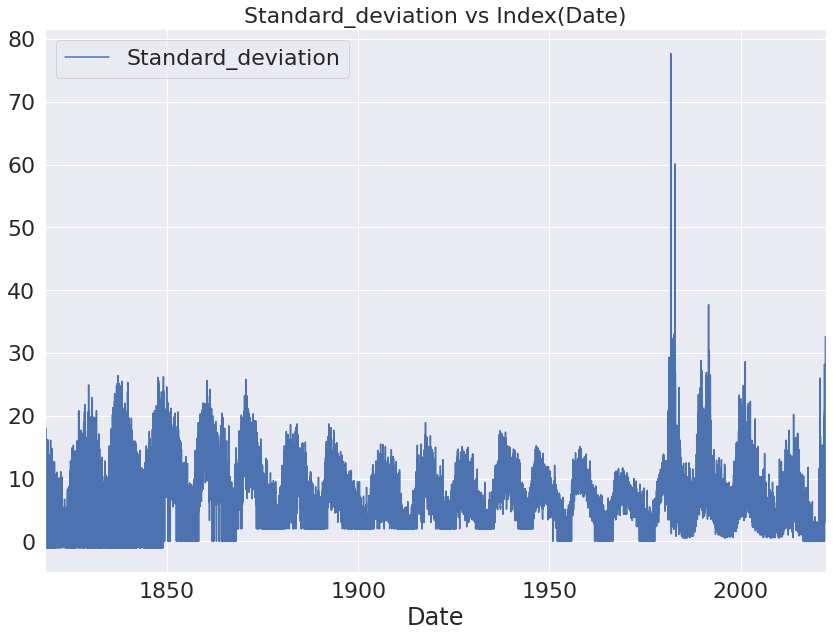

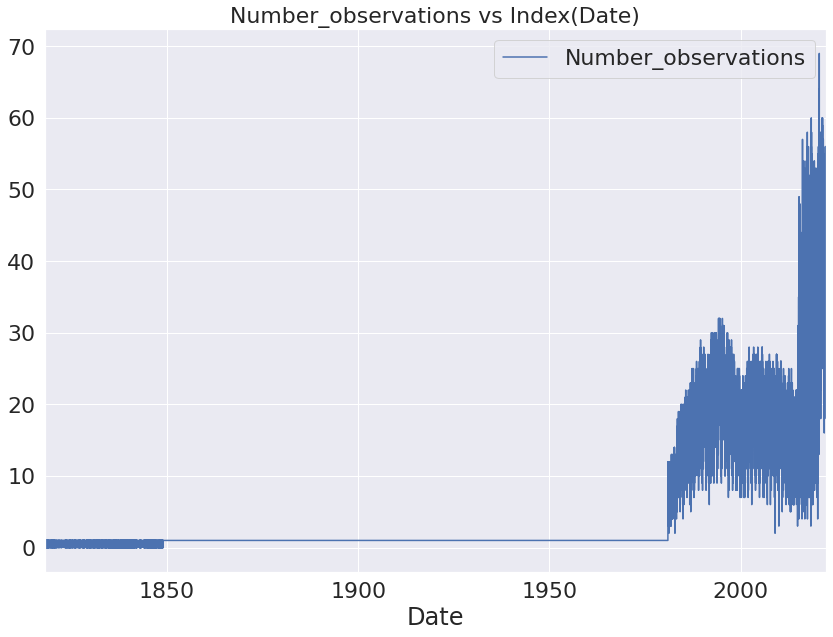

In [44]:
# load in dataset
df_daily = data_load("daily", ['Year', 'Month', 'Day', 'Decimal_year', 'Sunspot_number', 'Standard_deviation', 
          'Number_observations', 'Provisional_indicator'], 'D')

# simple & quick EDA
quick_look(df_daily)

# plot target vs index(date)
simple_plot_bulk(df_daily, "Sunspot_number", 'Standard_deviation', 'Number_observations')

### Features

'Year' - Year

'Month' - Month

'Day' - Day

'Decimal_year' - Date in fraction of year

'Daily_sunspot_number' -  Daily total sunspot number. A value of -1 indicates that no number is available for that day (missing value).

'Standard_deviation' - Daily standard deviation of the input sunspot numbers from individual stations.

'Number_observations' - Number of observations used to compute the daily value.

'Provisional_indicator' - Definitive/provisional indicator. A blank indicates that the value is definitive. A '*' symbol indicates that the value is still provisional and is subject to a possible revision (Usually the last 3 to 6 months)

No null values.
Note: the -1 values in Daily_sunspot_number

In [45]:
# if we have the mind to use only records with high number of observations
# df_daily = df_col_value_gt_or_eq(df_daily, 'Number_observations', 1)
# df_daily.head(50)

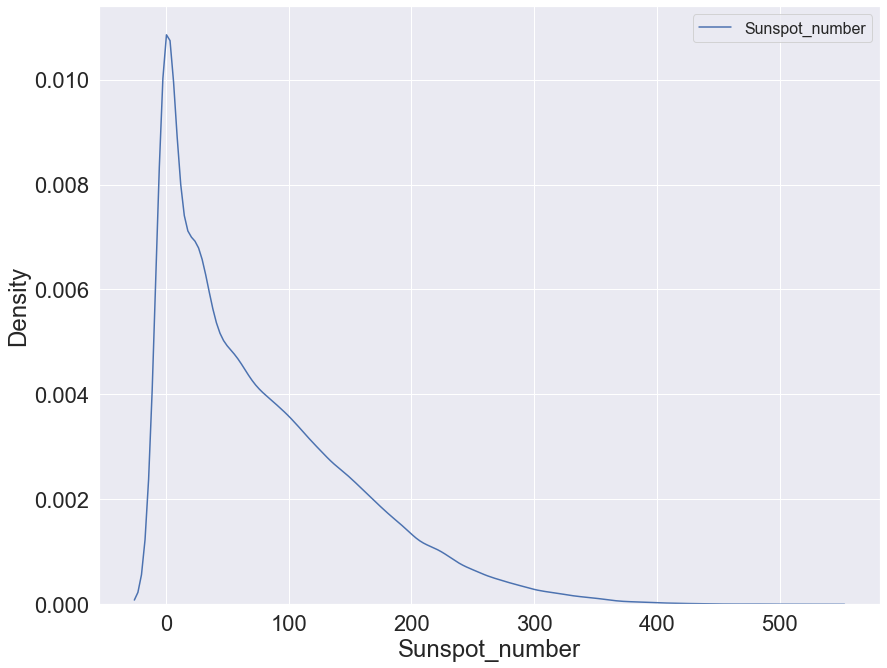

In [46]:
# distribution of values
plot_kde(['Sunspot_number'], df_daily['Sunspot_number'])

## Model

### Prep

In [47]:
# extract y
df_daily_model = extract_df(df_daily, 'Sunspot_number', 'y', 'ds')

In [48]:
# take a look at the data
display(df_daily_model.head())
display(df_daily_model.tail())

ds  y
Date                    
1818-01-01 1818-01-01 -1
1818-01-02 1818-01-02 -1
1818-01-03 1818-01-03 -1
1818-01-04 1818-01-04 -1
1818-01-05 1818-01-05 -1

ds    y
Date                      
2022-04-26 2022-04-26  132
2022-04-27 2022-04-27  132
2022-04-28 2022-04-28  135
2022-04-29 2022-04-29  107
2022-04-30 2022-04-30   51

In [49]:
# median fill
df_daily_model = handle_missing(df_daily_model)

ds     y
Date                       
1818-01-01 1818-01-01  None
1818-01-02 1818-01-02  None
1818-01-03 1818-01-03  None
1818-01-04 1818-01-04  None
1818-01-05 1818-01-05  None
...               ...   ...
1848-12-05 1848-12-05  None
1848-12-15 1848-12-15  None
1848-12-16 1848-12-16  None
1848-12-19 1848-12-19  None
1848-12-22 1848-12-22  None

[3247 rows x 2 columns]

Empty DataFrame
Columns: [ds, y]
Index: []

In [50]:
# confirm
df_daily_model

ds      y
Date                        
1818-01-01 1818-01-01   62.0
1818-01-02 1818-01-02   62.0
1818-01-03 1818-01-03   62.0
1818-01-04 1818-01-04   62.0
1818-01-05 1818-01-05   62.0
...               ...    ...
2022-04-26 2022-04-26  132.0
2022-04-27 2022-04-27  132.0
2022-04-28 2022-04-28  135.0
2022-04-29 2022-04-29  107.0
2022-04-30 2022-04-30   51.0

[74630 rows x 2 columns]

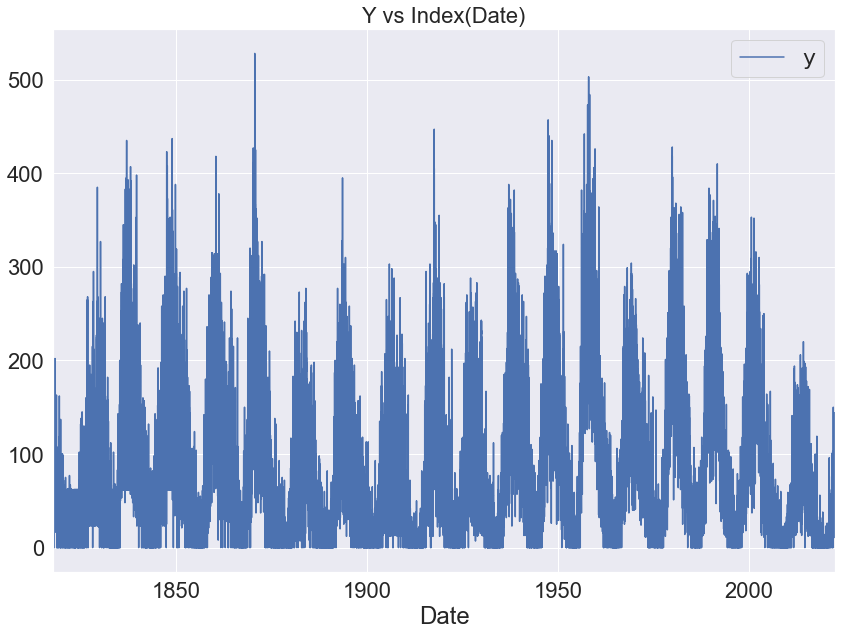

In [51]:
# plot target vs index(date)
simple_plot_bulk(df_daily_model, 'y')

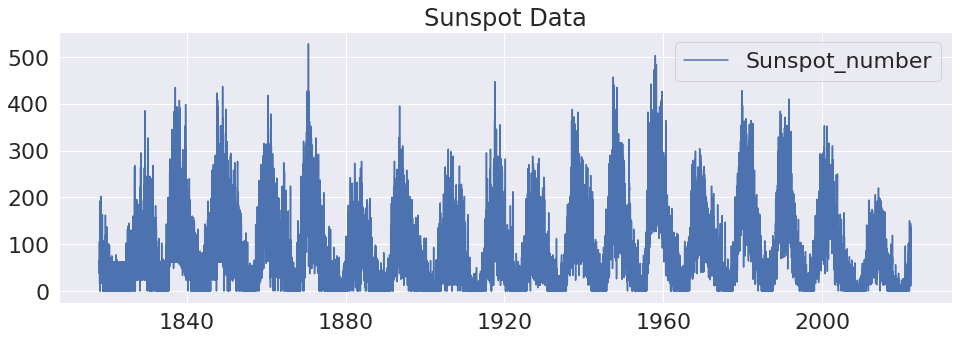

Results of Dickey-Fuller Test:
Test Statistic                -7.934017e+00
p-value                        3.452102e-12
#Lags Used                     6.300000e+01
Number of Observations Used    7.456600e+04
Critical Value (1%)           -3.430438e+00
Critical Value (5%)           -2.861579e+00
Critical Value (10%)          -2.566791e+00
dtype: float64
Conclusion
3.452102000963004e-12
Reject the null hypothesis: Stationary


In [52]:
# A key point to remember here is: Since the null hypothesis assumes the presence of unit root, that is α=1, 
# the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. 
# Thereby, inferring that the series is stationary

# The ADF tests gives the following results – test statistic, p-value and the critical value at 1%, 5% , and 
# 10% confidence intervals.
adf_test_show(df_daily_model, 'y')

In [53]:
# If Test statistic > Critical Value and p-value > 0.05 – Fail to Reject Null Hypothesis(HO) i.e., 
# time series does not have a unit root, meaning it is trend stationary.
kpss_test(df_daily_model['y'])

Results of KPSS Test:
Test Statistic             0.845332
p-value                    0.010000
#Lags Used               155.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64
Conclusion
0.01
Reject the null hypothesis: Non-Stationary


C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


ADF concludes stationary and KPSS concludes non-stationary – The series is difference stationary. Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity.

# FBProphet

### Simple model 

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


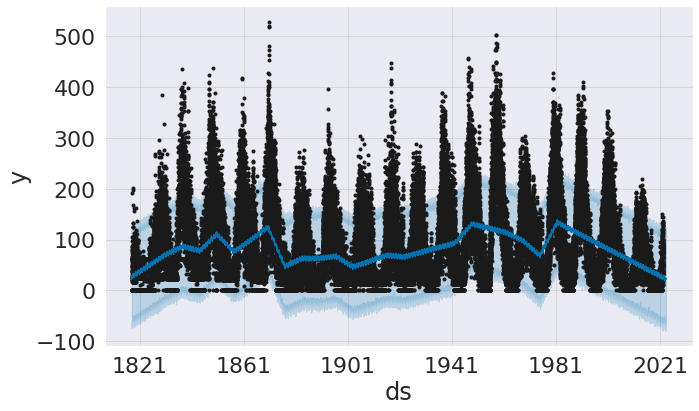

In [25]:
# Python
m_1 = Prophet(daily_seasonality=True)
m_1.fit(df_daily_model)
future = m_1.make_future_dataframe(365, freq='D')
forecast = m_1.predict(future)
fig = m_1.plot(forecast)

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


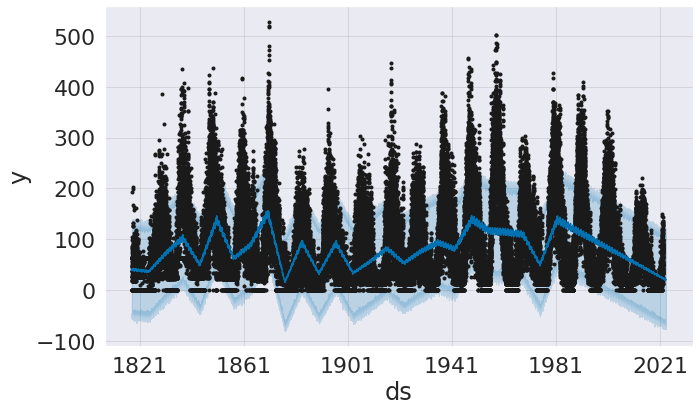

In [26]:
# Python
m = Prophet(daily_seasonality=True, seasonality_mode='multiplicative')
m.fit(df_daily_model)
future = m.make_future_dataframe(365, freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)

# Simple Custom Model

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
74725 2022-08-04  4.883613  -36.550437  104.721594     4.883613     4.883613   
74726 2022-08-05  4.882721  -42.216390   91.049521     4.882721     4.882721   
74727 2022-08-06  4.881828  -35.882377   98.472239     4.881828     4.881828   
74728 2022-08-07  4.880936  -35.774623  104.828273     4.880936     4.880936   
74729 2022-08-08  4.880043  -40.195230  106.189655     4.880043     4.880043   

       11_yearly  11_yearly_lower  11_yearly_upper     daily  ...  \
74725  -0.215524        -0.215524        -0.215524  5.638213  ...   
74726  -0.205907        -0.205907        -0.205907  5.638213  ...   
74727  -0.196506        -0.196506        -0.196506  5.638213  ...   
74728  -0.187325        -0.187325        -0.187325  5.638213  ...   
74729  -0.178364        -0.178364        -0.178364  5.638213  ...   

       multiplicative_terms  multiplicative_terms_lower  \
74725              5.295590                    5.295590   
74726              5.389570                    5.389570   
74727              5.544288                    5.544288   
74728              5.633946                    5.633946   
74729              5.660128                    5.660128   

       multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
74725                    5.295590 -0.063153     -0.063153     -0.063153   
74726                    5.389570 -0.021218     -0.021218     -0.021218   
74727                    5.544288  0.022021      0.022021      0.022021   
74728                    5.633946  0.068384      0.068384      0.068384   
74729                    5.660128  0.118902      0.118902      0.118902   

       additive_terms  additive_terms_lower  additive_terms_upper       yhat  
74725             0.0                   0.0                   0.0  30.745228  
74726             0.0                   0.0                   0.0  31.198487  
74727             0.0                   0.0                   0.0  31.948092  
74728             0.0                   0.0                   0.0  32.379863  
74729             0.0                   0.0                   0.0  32.501714  

[5 rows x 25 columns]

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarnin

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
74825 2022-11-12  4.794357  -32.720362  100.703689     4.794357     4.794357   
74826 2022-11-13  4.793464  -32.705797  106.804435     4.793464     4.793464   
74827 2022-11-14  4.792571  -33.376521  106.315543     4.792571     4.792571   
74828 2022-11-15  4.791679  -37.992316  107.894671     4.791679     4.791679   
74829 2022-11-16  4.790786  -39.404269  106.256542     4.790786     4.790786   

       11_yearly  11_yearly_lower  11_yearly_upper     daily  ...  \
74825   0.428085         0.428085         0.428085  5.638213  ...   
74826   0.442374         0.442374         0.442374  5.638213  ...   
74827   0.456916         0.456916         0.456916  5.638213  ...   
74828   0.471706         0.471706         0.471706  5.638213  ...   
74829   0.486738         0.486738         0.486738  5.638213  ...   

       multiplicative_terms  multiplicative_terms_lower  \
74825              6.246252                    6.246252   
74826              6.313469                    6.313469   
74827              6.283724                    6.283724   
74828              6.300069                    6.300069   
74829              6.212661                    6.212661   

       multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
74825                    6.246252  0.075377      0.075377      0.075377   
74826                    6.313469  0.077658      0.077658      0.077658   
74827                    6.283724  0.062245      0.062245      0.062245   
74828                    6.300069  0.029609      0.029609      0.029609   
74829                    6.212661 -0.017172     -0.017172     -0.017172   

       additive_terms  additive_terms_lower  additive_terms_upper       yhat  
74825             0.0                   0.0                   0.0  34.741116  
74826             0.0                   0.0                   0.0  35.056850  
74827             0.0                   0.0                   0.0  34.907765  
74828             0.0                   0.0                   0.0  34.979585  
74829             0.0                   0.0                   0.0  34.554319  

[5 rows x 25 columns]

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarnin

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
74990 2023-04-26  4.647083  -32.563947  107.406943     4.647083     4.647083   
74991 2023-04-27  4.646190  -34.961674  103.234296     4.646190     4.646190   
74992 2023-04-28  4.645297  -39.249298  105.458401     4.645297     4.645297   
74993 2023-04-29  4.644405  -28.932427  110.396833     4.644405     4.644405   
74994 2023-04-30  4.643512  -32.572702  108.273136     4.643512     4.643512   

       11_yearly  11_yearly_lower  11_yearly_upper     daily  ...  \
74990   1.158339         1.158339         1.158339  5.638213  ...   
74991   1.159529         1.159529         1.159529  5.638213  ...   
74992   1.161124         1.161124         1.161124  5.638213  ...   
74993   1.163125         1.163125         1.163125  5.638213  ...   
74994   1.165534         1.165534         1.165534  5.638213  ...   

       multiplicative_terms  multiplicative_terms_lower  \
74990              6.622952                    6.622952   
74991              6.653652                    6.653652   
74992              6.722202                    6.722202   
74993              6.807319                    6.807319   
74994              6.710430                    6.710430   

       multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
74990                    6.622952 -0.047523     -0.047523     -0.047523   
74991                    6.653652 -0.077550     -0.077550     -0.077550   
74992                    6.722202 -0.100946     -0.100946     -0.100946   
74993                    6.807319 -0.112740     -0.112740     -0.112740   
74994                    6.710430 -0.109527     -0.109527     -0.109527   

       additive_terms  additive_terms_lower  additive_terms_upper       yhat  
74990             0.0                   0.0                   0.0  35.424486  
74991             0.0                   0.0                   0.0  35.560320  
74992             0.0                   0.0                   0.0  35.871924  
74993             0.0                   0.0                   0.0  36.260352  
74994             0.0                   0.0                   0.0  35.803477  

[5 rows x 25 columns]

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarnin

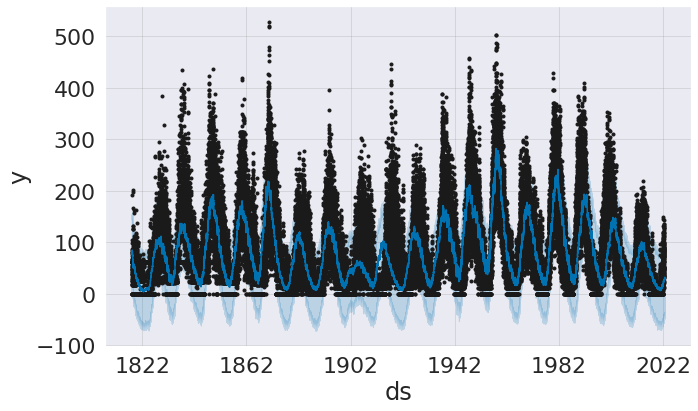

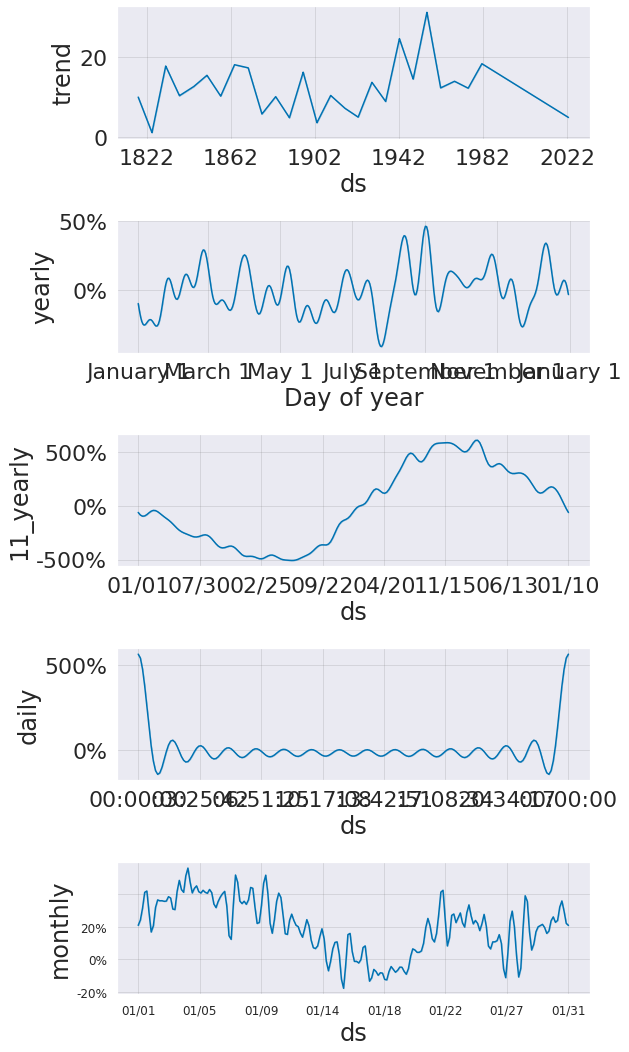

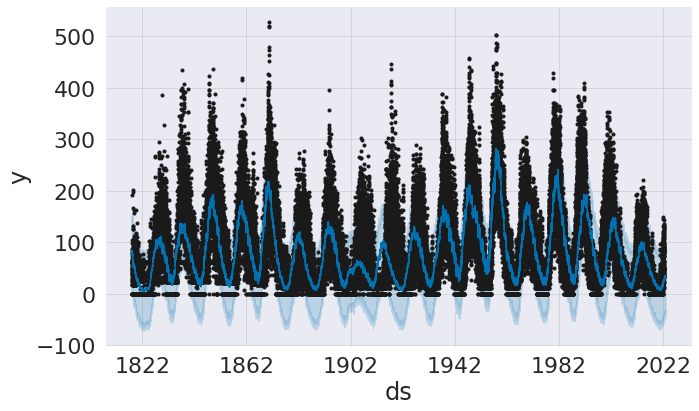

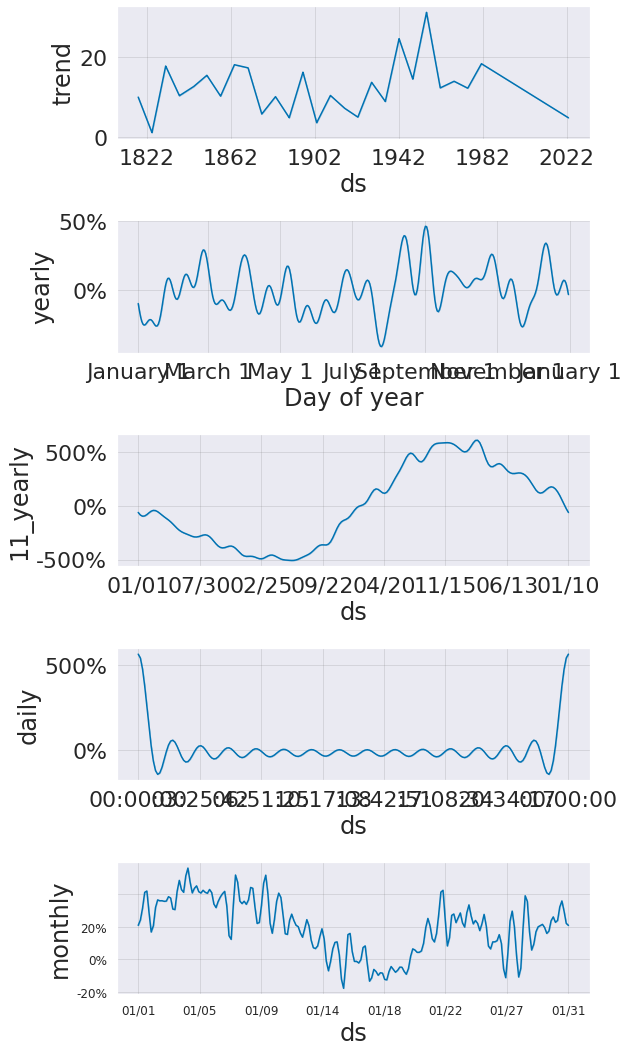

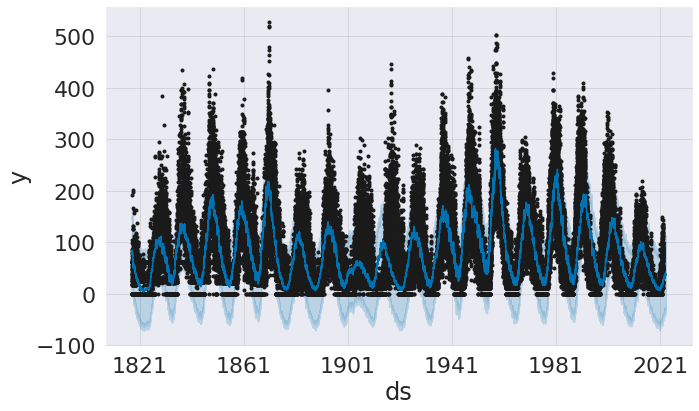

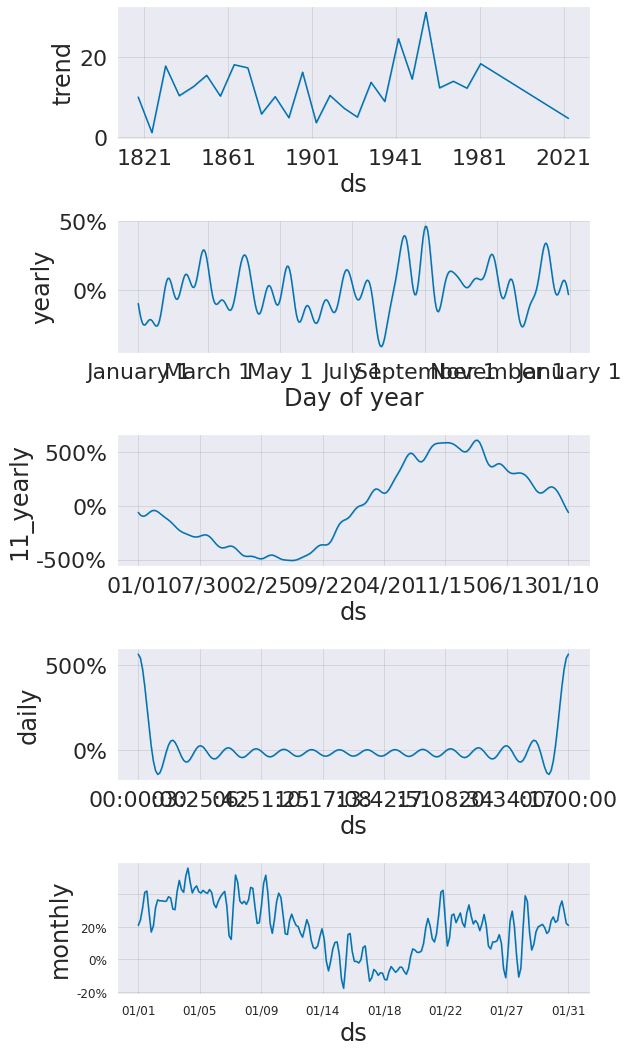

In [55]:
fb_prophet_model, future_dates_1, forcast_1, future_dates_2, forcast_2, future_dates_3, forcast_3 = simple_prophet_model(df_daily_model, 100, 200, 365, 'D', True, True)

Train dates : 1818-01-01 00:00:00 --- 2022-01-20 00:00:00  (n=74530)
Test dates  : 2022-01-21 00:00:00 --- 2022-04-30 00:00:00  (n=100)


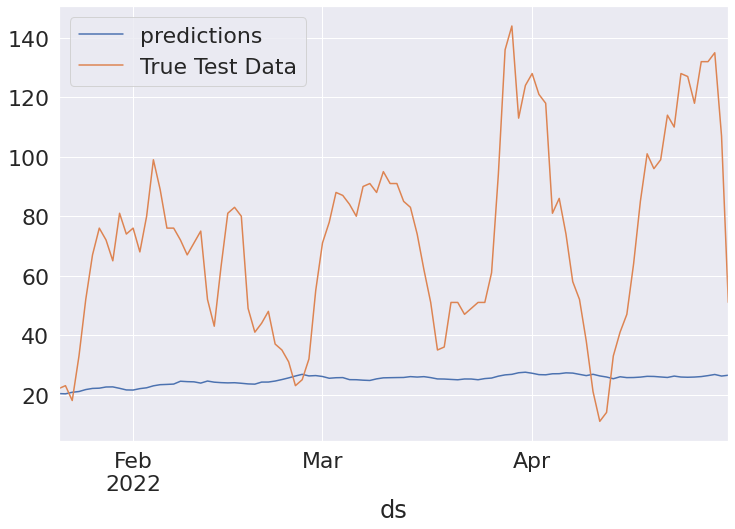

In [88]:
data_train, data_test = split(df_daily_model, 100)
plot_test_predict(data_test, forcast_1[-200:-100])

Train dates : 1818-01-01 00:00:00 --- 2021-10-12 00:00:00  (n=74430)
Test dates  : 2021-10-13 00:00:00 --- 2022-04-30 00:00:00  (n=200)


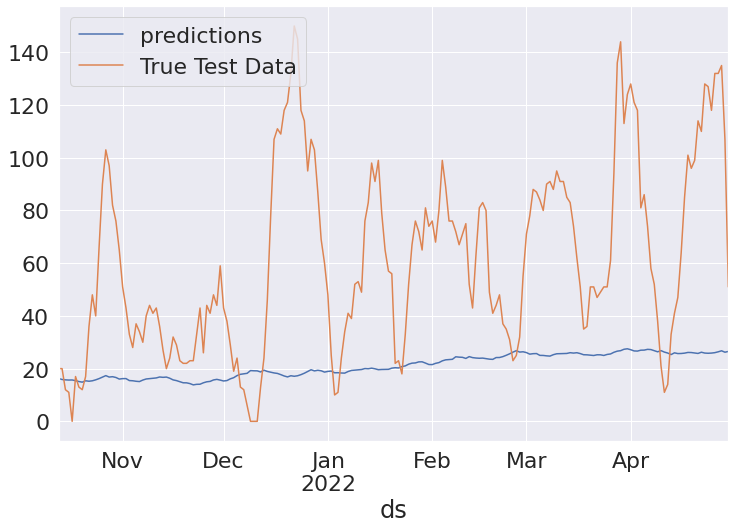

In [89]:
data_train, data_test = split(df_daily_model, 200)
plot_test_predict(data_test, forcast_2[-400:-200])

Train dates : 1818-01-01 00:00:00 --- 2021-04-30 00:00:00  (n=74265)
Test dates  : 2021-05-01 00:00:00 --- 2022-04-30 00:00:00  (n=365)


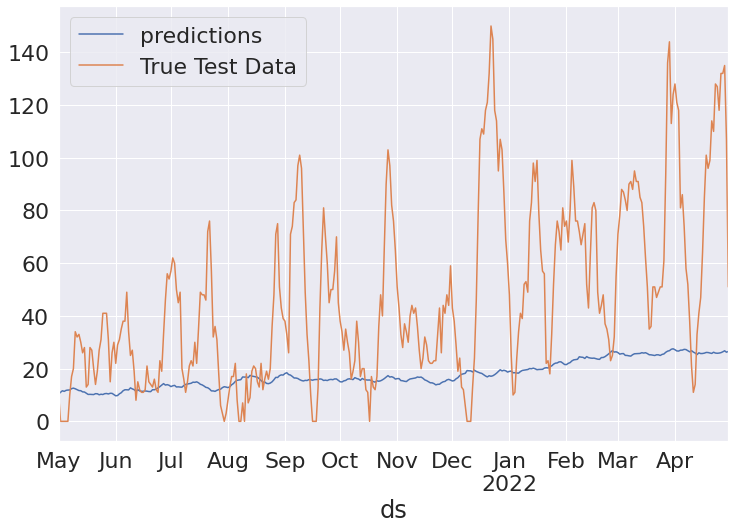

In [101]:
data_train, data_test = split(df_daily_model, 365)
plot_test_predict(data_test, forcast_3[-730:-365])

In [64]:
initial = df_daily_model.shape[0] / 2

period = initial / 4

horizon = initial / 2

In [65]:
prophet, forcast, cv_results = model_with_cv(df_daily_model, 'linear', 'D', 365, initial, period, horizon, 'days')

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 2 forecasts with cutoffs between 1945-09-14 18:00:00 and 1971-03-31 12:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

INFO:fbprophet:Skipping MAPE because y close to 0


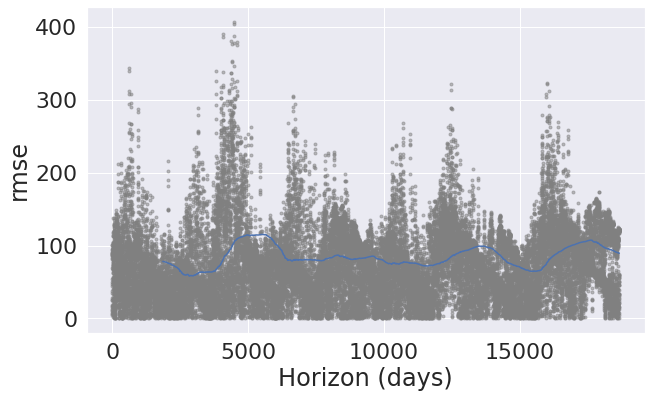

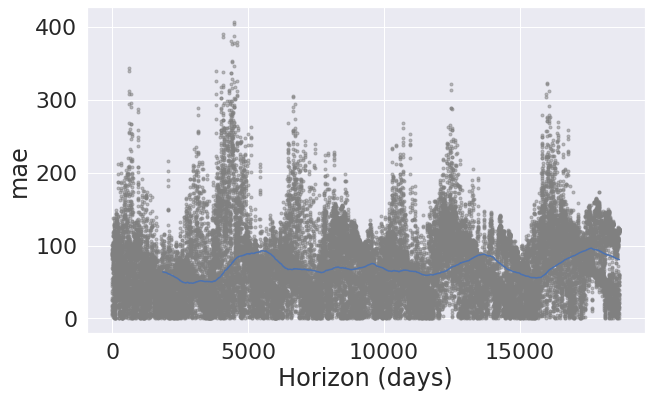

In [71]:
# get metrics on model
get_performance_metrics_plot(cv_results)

Train dates : 1818-01-01 00:00:00 --- 2021-04-30 00:00:00  (n=74265)
Test dates  : 2021-05-01 00:00:00 --- 2022-04-30 00:00:00  (n=365)


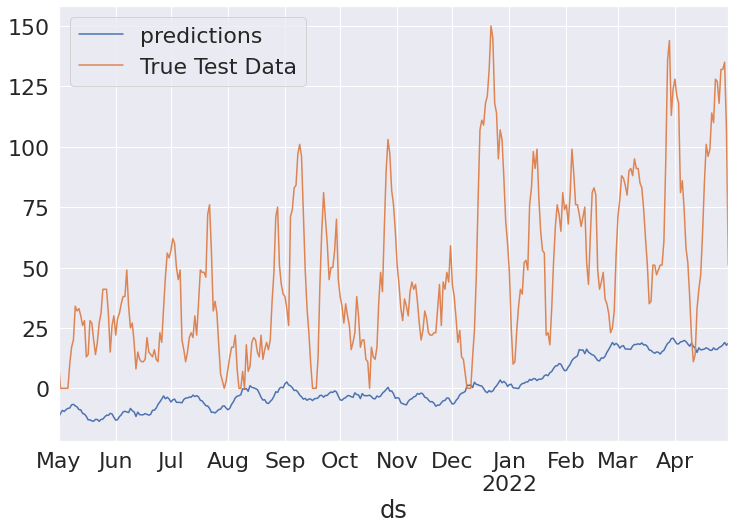

In [186]:
data_train, data_test = split(df_daily_model, 365)
plot_test_predict(data_test, forcast[-730:-365])

In [193]:
mean_absolute_error(np.array(data_test["y"]), np.array(forcast.yhat[-730:-365]))

46.36536549229937

In [194]:
mean_absolute_percentage_error(np.array(data_test["y"]), np.array(forcast.yhat[-730:-365]))

987269422804166.9

In [195]:
r2_score(np.array(data_test["y"]), np.array(forcast.yhat[-730:-365]))

-1.6442459546691945

In [200]:
data_train, data_test = split(df_daily_model, 365)

Train dates : 1818-01-01 00:00:00 --- 2021-04-30 00:00:00  (n=74265)
Test dates  : 2021-05-01 00:00:00 --- 2022-04-30 00:00:00  (n=365)


In [206]:
prophet_d_2, forcast_d_2, cv_results_d_2 = model_with_cv(data_train, 'logistic', 39, 30, 30, 'D', 365, initial, period, horizon, 'days', monthly=True, daily=True)

C:\Users\akame\AppData\Local\Temp\ipykernel_20692\1129956497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cap'] = 500
C:\Users\akame\AppData\Local\Temp\ipykernel_20692\1129956497.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['floor'] = 1
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(ne

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

INFO:fbprophet:Skipping MAPE because y close to 0


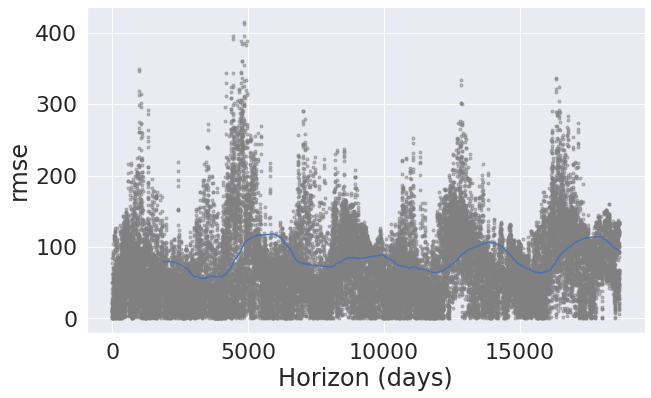

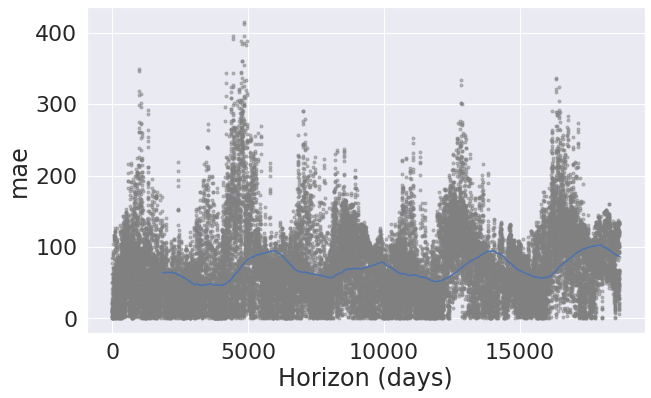

In [214]:
# get metrics on model
get_performance_metrics_plot(cv_results_d_2)

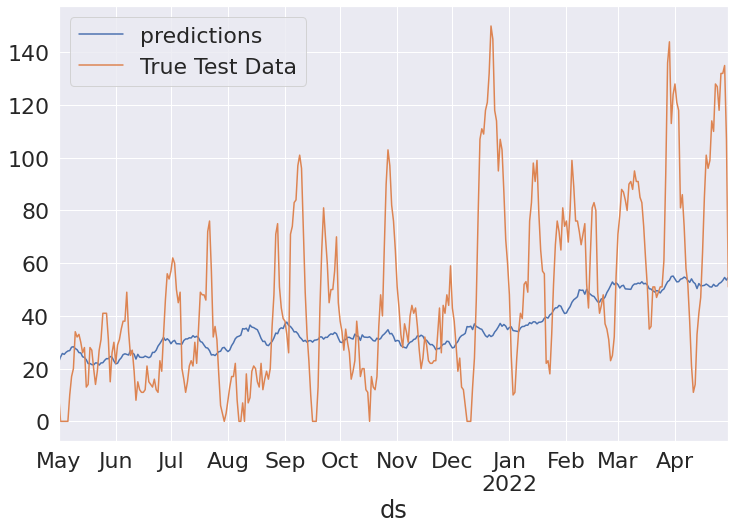

In [215]:
plot_test_predict(data_test, forcast_d_2[-365:])

In [216]:
mean_absolute_error(np.array(data_test["y"]), np.array(forcast.yhat[-365:]))

24.84008937761477

In [217]:
mean_absolute_percentage_error(np.array(data_test["y"]), np.array(forcast.yhat[-365:]))

5485344368687209.0

In [218]:
r2_score(np.array(data_test["y"]), np.array(forcast.yhat[-365:]))

-0.006560427364540544

# Monthly

## Data and brief EDA

Year  Month  Day  Decimal_year  Sunspot_number  \
Date                                                         
1749-01-01  1749      1    1      1749.042            96.7   
1749-02-01  1749      2    1      1749.123           104.3   
1749-03-01  1749      3    1      1749.204           116.7   
1749-04-01  1749      4    1      1749.288            92.8   
1749-05-01  1749      5    1      1749.371           141.7   

            Standard_deviation  Number_observations  Provisional_indicator  \
Date                                                                         
1749-01-01                -1.0                   -1                      1   
1749-02-01                -1.0                   -1                      1   
1749-03-01                -1.0                   -1                      1   
1749-04-01                -1.0                   -1                      1   
1749-05-01                -1.0                   -1                      1   

                   ds  
Date                   
1749-01-01 1749-01-01  
1749-02-01 1749-02-01  
1749-03-01 1749-03-01  
1749-04-01 1749-04-01  
1749-05-01 1749-05-01

Year  Month  Day  Decimal_year  Sunspot_number  \
Date                                                         
2021-12-01  2021     12    1      2021.958            67.5   
2022-01-01  2022      1    1      2022.042            54.0   
2022-02-01  2022      2    1      2022.122            59.7   
2022-03-01  2022      3    1      2022.204            78.5   
2022-04-01  2022      4    1      2022.286            84.1   

            Standard_deviation  Number_observations  Provisional_indicator  \
Date                                                                         
2021-12-01                15.6                  845                      1   
2022-01-01                12.9                 1007                      0   
2022-02-01                13.1                 1044                      0   
2022-03-01                13.9                 1277                      0   
2022-04-01                15.2                 1237                      0   

                   ds  
Date                   
2021-12-01 2021-12-01  
2022-01-01 2022-01-01  
2022-02-01 2022-02-01  
2022-03-01 2022-03-01  
2022-04-01 2022-04-01

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3280 entries, 1749-01-01 to 2022-04-01
Freq: MS
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Year                   3280 non-null   int64         
 1   Month                  3280 non-null   int64         
 2   Day                    3280 non-null   int64         
 3   Decimal_year           3280 non-null   float64       
 4   Sunspot_number         3280 non-null   float64       
 5   Standard_deviation     3280 non-null   float64       
 6   Number_observations    3280 non-null   int64         
 7   Provisional_indicator  3280 non-null   int64         
 8   ds                     3280 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 256.2 KB


None

Year        Month     Day  Decimal_year  Sunspot_number  \
count  3280.000000  3280.000000  3280.0   3280.000000     3280.000000   
mean   1885.167073     6.495122     1.0   1885.664664       81.594329   
std      78.916744     3.453518     0.0     78.916547       67.805438   
min    1749.000000     1.000000     1.0   1749.042000        0.000000   
25%    1817.000000     3.000000     1.0   1817.350250       23.900000   
50%    1885.000000     6.000000     1.0   1885.665000       66.850000   
75%    1953.250000     9.000000     1.0   1953.979000      122.400000   
max    2022.000000    12.000000     1.0   2022.286000      398.200000   

       Standard_deviation  Number_observations  Provisional_indicator  
count         3280.000000          3280.000000            3280.000000  
mean             5.567896           110.492988               0.998780  
std              5.220310           234.964151               0.034906  
min             -1.000000            -1.000000               0.000000  
25%             -1.000000            -1.000000               1.000000  
50%              5.300000            30.000000               1.000000  
75%              9.400000            31.000000               1.000000  
max             23.500000          1587.000000               1.000000

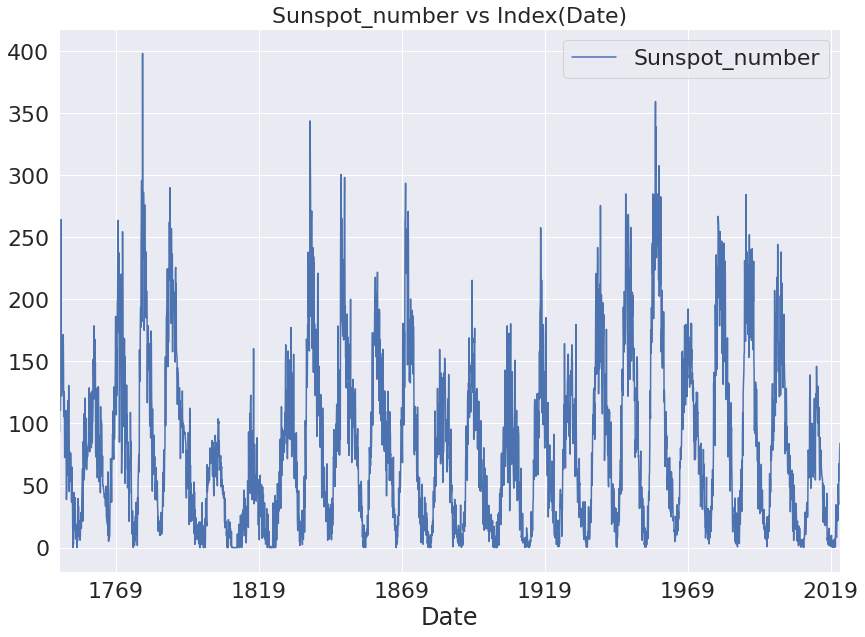

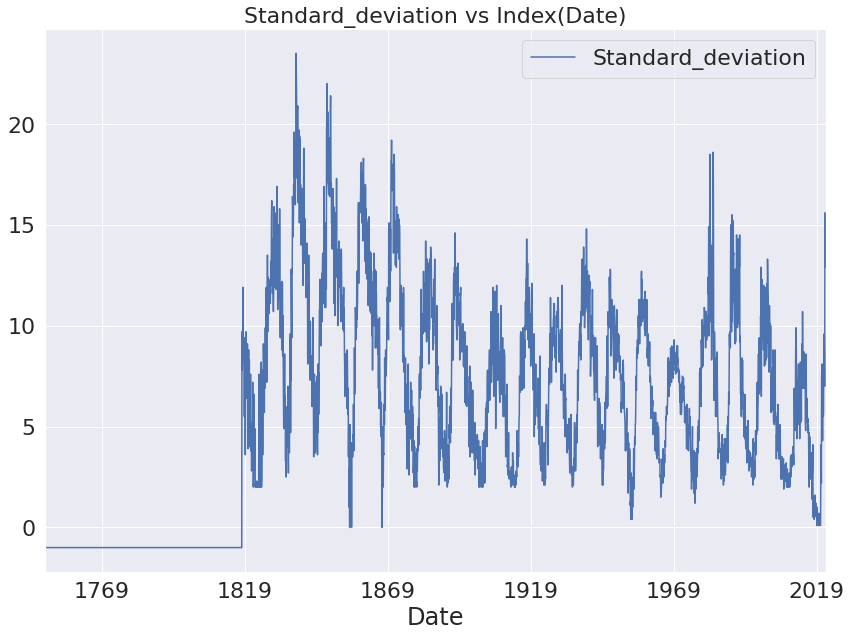

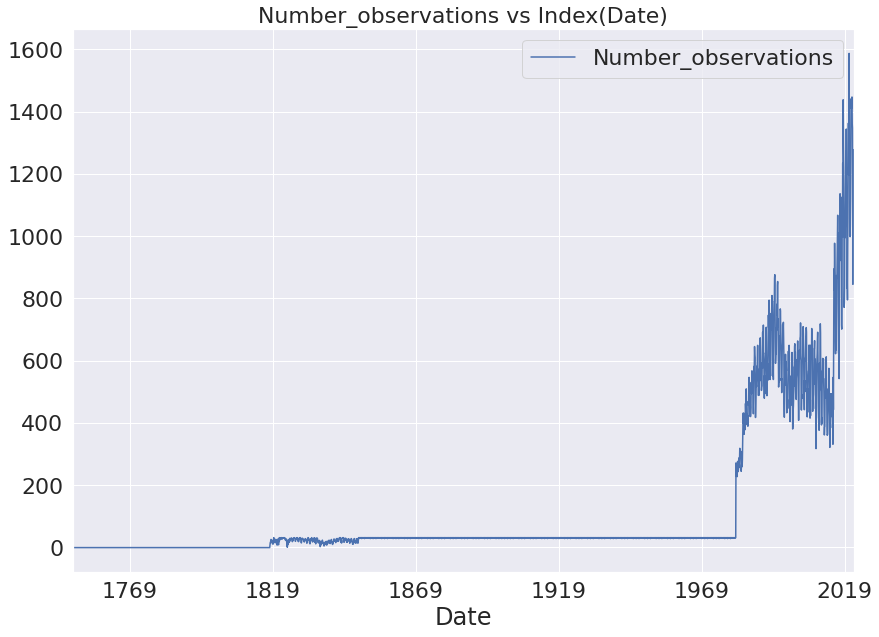

In [102]:
# load in dataset
df_monthly = data_load("monthly", ['Year', 'Month', 'Decimal_year', 'Sunspot_number', 'Standard_deviation', 
          'Number_observations', 'Provisional_indicator'], 'MS')

# simple & quick EDA
quick_look(df_monthly)

# plot target vs index(date)
simple_plot_bulk(df_monthly, "Sunspot_number", 'Standard_deviation', 'Number_observations')


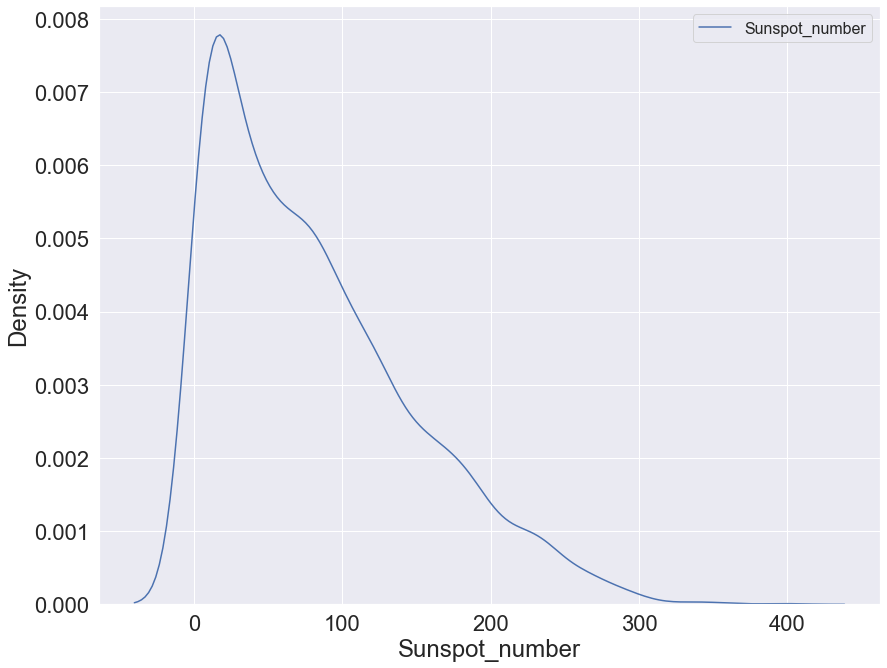

In [103]:
# distribution of values
plot_kde(['Sunspot_number'], df_monthly['Sunspot_number'])

## Model

In [104]:
# extract y
df_monthly_model = extract_df(df_monthly, 'Sunspot_number', 'y', 'ds')

In [105]:
# take a look at the data
display(df_monthly_model.head())
display(df_monthly_model.tail())

ds      y
Date                        
1749-01-01 1749-01-01   96.7
1749-02-01 1749-02-01  104.3
1749-03-01 1749-03-01  116.7
1749-04-01 1749-04-01   92.8
1749-05-01 1749-05-01  141.7

ds     y
Date                       
2021-12-01 2021-12-01  67.5
2022-01-01 2022-01-01  54.0
2022-02-01 2022-02-01  59.7
2022-03-01 2022-03-01  78.5
2022-04-01 2022-04-01  84.1

In [106]:
# median fill
df_monthly_model = handle_missing(df_monthly_model)

Empty DataFrame
Columns: [ds, y]
Index: []

Empty DataFrame
Columns: [ds, y]
Index: []

In [107]:
# confirm
df_monthly_model

ds      y
Date                        
1749-01-01 1749-01-01   96.7
1749-02-01 1749-02-01  104.3
1749-03-01 1749-03-01  116.7
1749-04-01 1749-04-01   92.8
1749-05-01 1749-05-01  141.7
...               ...    ...
2021-12-01 2021-12-01   67.5
2022-01-01 2022-01-01   54.0
2022-02-01 2022-02-01   59.7
2022-03-01 2022-03-01   78.5
2022-04-01 2022-04-01   84.1

[3280 rows x 2 columns]

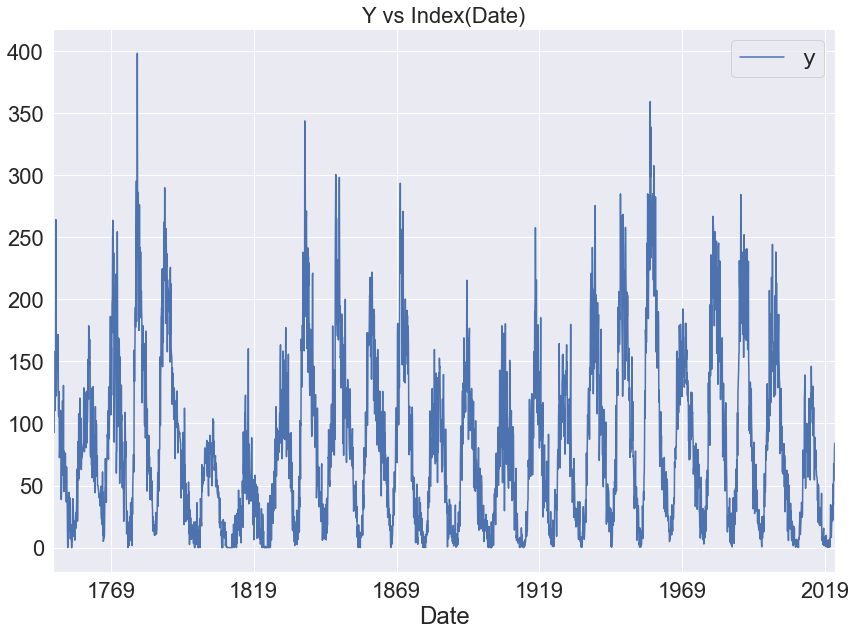

In [108]:
# plot target vs index(date)
simple_plot_bulk(df_monthly_model, 'y')

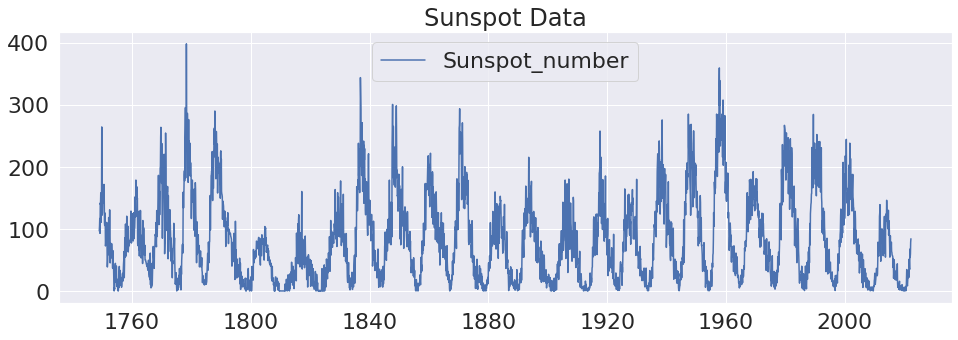

Results of Dickey-Fuller Test:
Test Statistic                -1.056965e+01
p-value                        7.361427e-19
#Lags Used                     2.800000e+01
Number of Observations Used    3.251000e+03
Critical Value (1%)           -3.432363e+00
Critical Value (5%)           -2.862429e+00
Critical Value (10%)          -2.567243e+00
dtype: float64
Conclusion
7.3614268702497105e-19
Reject the null hypothesis: Stationary


In [109]:
# A key point to remember here is: Since the null hypothesis assumes the presence of unit root, that is α=1, 
# the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. 
# Thereby, inferring that the series is stationary

# The ADF tests gives the following results – test statistic, p-value and the critical value at 1%, 5% , and 
# 10% confidence intervals.
adf_test_show(df_monthly_model, 'y')

In [110]:
# If Test statistic > Critical Value and p-value > 0.05 – Fail to Reject Null Hypothesis(HO) i.e., 
# time series does not have a unit root, meaning it is trend stationary.
kpss_test(df_monthly_model['y'])

Results of KPSS Test:
Test Statistic            0.099185
p-value                   0.100000
#Lags Used               36.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Conclusion
0.1
DO NOT Reject the null hypothesis: Stationary


C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## FBProphet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


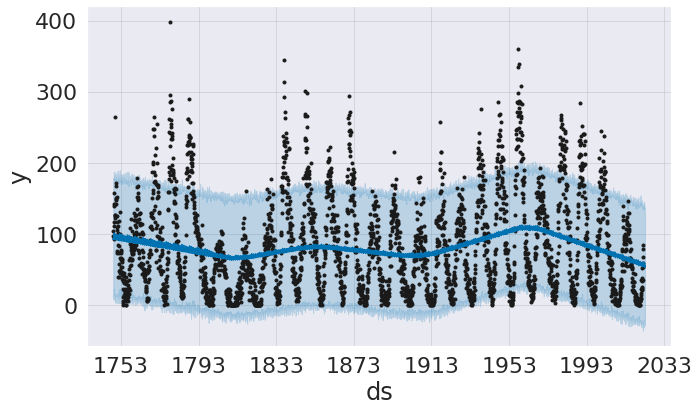

In [114]:
# Python
m_m_1 = Prophet()
m_m_1.fit(df_monthly_model)
future = m_m_1.make_future_dataframe(9, freq='MS')
forecast = m_m_1.predict(future)
fig = m_m_1.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


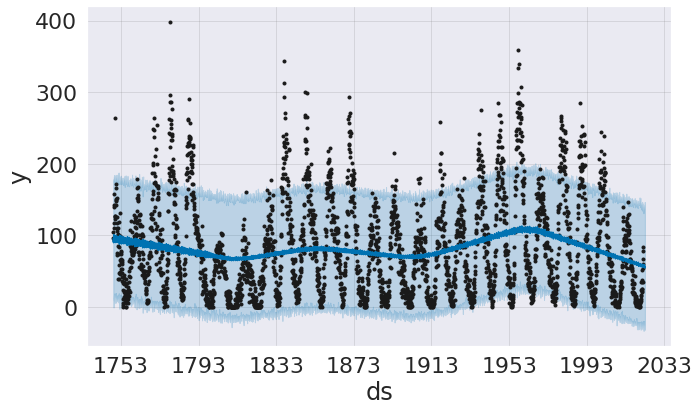

In [115]:
# Python
m_m_1 = Prophet(seasonality_mode='multiplicative')
m_m_1.fit(df_monthly_model)
future = m_m_1.make_future_dataframe(9, freq='MS')
forecast = m_m_1.predict(future)
fig = m_m_1.plot(forecast)

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
3276 2022-01-01  7.712741    9.258132  122.322916     7.712741     7.712741   
3277 2022-02-01  7.698902   14.532414  129.185346     7.698902     7.698902   
3278 2022-03-01  7.686402  -17.568596  103.106793     7.686402     7.686402   
3279 2022-04-01  7.672563   -9.812172  106.386054     7.672563     7.672563   
3280 2022-05-01  7.659170  -17.820381   98.630554     7.659170     7.659170   

      11_yearly  11_yearly_lower  11_yearly_upper   monthly  ...  \
3276  -1.814034        -1.814034        -1.814034  3.783418  ...   
3277  -1.065609        -1.065609        -1.065609  3.090523  ...   
3278  -0.611406        -0.611406        -0.611406 -0.744174  ...   
3279  -0.584456        -0.584456        -0.584456 -0.193003  ...   
3280  -0.857793        -0.857793        -0.857793 -0.744174  ...   

      multiplicative_terms  multiplicative_terms_lower  \
3276              8.193172                    8.193172   
3277              8.367016                    8.367016   
3278              4.499964                    4.499964   
3279              4.915622                    4.915622   
3280              4.157460                    4.157460   

      multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
3276                    8.193172  6.223788      6.223788      6.223788   
3277                    8.367016  6.342103      6.342103      6.342103   
3278                    4.499964  5.855544      5.855544      5.855544   
3279                    4.915622  5.693081      5.693081      5.693081   
3280                    4.157460  5.759426      5.759426      5.759426   

      additive_terms  additive_terms_lower  additive_terms_upper       yhat  
3276             0.0                   0.0                   0.0  70.904556  
3277             0.0                   0.0                   0.0  72.115739  
3278             0.0                   0.0                   0.0  42.274936  
3279             0.0                   0.0                   0.0  45.387979  
3280             0.0                   0.0                   0.0  39.501861  

[5 rows x 22 columns]

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarnin

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
3281 2022-06-01  7.645331  -14.477241   95.985738     7.645331     7.645331   
3282 2022-07-01  7.631939  -18.036132   95.325363     7.631939     7.631939   
3283 2022-08-01  7.618099   -1.986724  107.034833     7.618099     7.618099   
3284 2022-09-01  7.604260   15.554102  123.760922     7.604260     7.604260   
3285 2022-10-01  7.590868   -0.683231  109.302396     7.590868     7.590868   

      11_yearly  11_yearly_lower  11_yearly_upper   monthly  ...  \
3281  -1.034267        -1.034267        -1.034267 -0.193003  ...   
3282  -0.900859        -0.900859        -0.900859 -0.744174  ...   
3283  -0.615256        -0.615256        -0.615256 -0.193003  ...   
3284  -0.441217        -0.441217        -0.441217  2.126176  ...   
3285  -0.351583        -0.351583        -0.351583 -0.193003  ...   

      multiplicative_terms  multiplicative_terms_lower  \
3281              4.624787                    4.624787   
3282              4.393499                    4.393499   
3283              5.561731                    5.561731   
3284              8.046423                    8.046423   
3285              5.718765                    5.718765   

      multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
3281                    4.624787  5.852058      5.852058      5.852058   
3282                    4.393499  6.038531      6.038531      6.038531   
3283                    5.561731  6.369989      6.369989      6.369989   
3284                    8.046423  6.361464      6.361464      6.361464   
3285                    5.718765  6.263351      6.263351      6.263351   

      additive_terms  additive_terms_lower  additive_terms_upper       yhat  
3281             0.0                   0.0                   0.0  43.003360  
3282             0.0                   0.0                   0.0  41.162851  
3283             0.0                   0.0                   0.0  49.987917  
3284             0.0                   0.0                   0.0  68.791359  
3285             0.0                   0.0                   0.0  51.001257  

[5 rows x 22 columns]

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarnin

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
3284 2022-09-01  7.604260    9.359481  125.649261     7.604260     7.604260   
3285 2022-10-01  7.590868   -5.036902  109.436941     7.590868     7.590868   
3286 2022-11-01  7.577029   11.566874  126.982644     7.577029     7.577029   
3287 2022-12-01  7.563636   -2.527021  117.348963     7.563636     7.563636   
3288 2023-01-01  7.549797   20.323768  136.364790     7.549797     7.549797   

      11_yearly  11_yearly_lower  11_yearly_upper   monthly  ...  \
3284  -0.441217        -0.441217        -0.441217  2.126176  ...   
3285  -0.351583        -0.351583        -0.351583 -0.193003  ...   
3286  -0.040925        -0.040925        -0.040925  2.126176  ...   
3287   0.626989         0.626989         0.626989 -0.193003  ...   
3288   1.429848         1.429848         1.429848  2.126176  ...   

      multiplicative_terms  multiplicative_terms_lower  \
3284              8.046423                    8.046423   
3285              5.718765                    5.718765   
3286              7.981532                    7.981532   
3287              6.572697                    6.572697   
3288              9.491285                    9.491285   

      multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
3284                    8.046423  6.361464      6.361464      6.361464   
3285                    5.718765  6.263351      6.263351      6.263351   
3286                    7.981532  5.896282      5.896282      5.896282   
3287                    6.572697  6.138712      6.138712      6.138712   
3288                    9.491285  5.935261      5.935261      5.935261   

      additive_terms  additive_terms_lower  additive_terms_upper       yhat  
3284             0.0                   0.0                   0.0  68.791359  
3285             0.0                   0.0                   0.0  51.001257  
3286             0.0                   0.0                   0.0  68.053325  
3287             0.0                   0.0                   0.0  57.277126  
3288             0.0                   0.0                   0.0  79.207070  

[5 rows x 22 columns]

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarnin

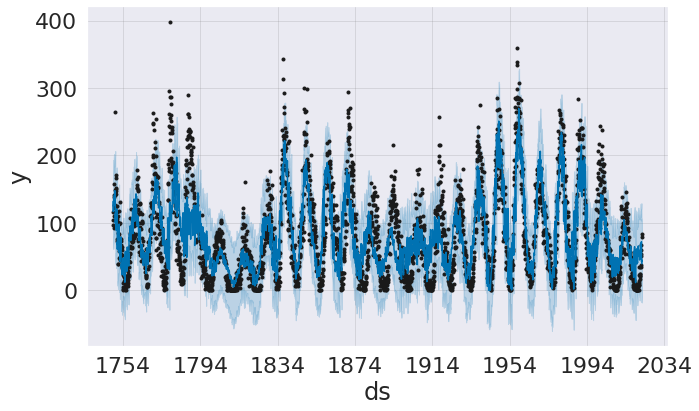

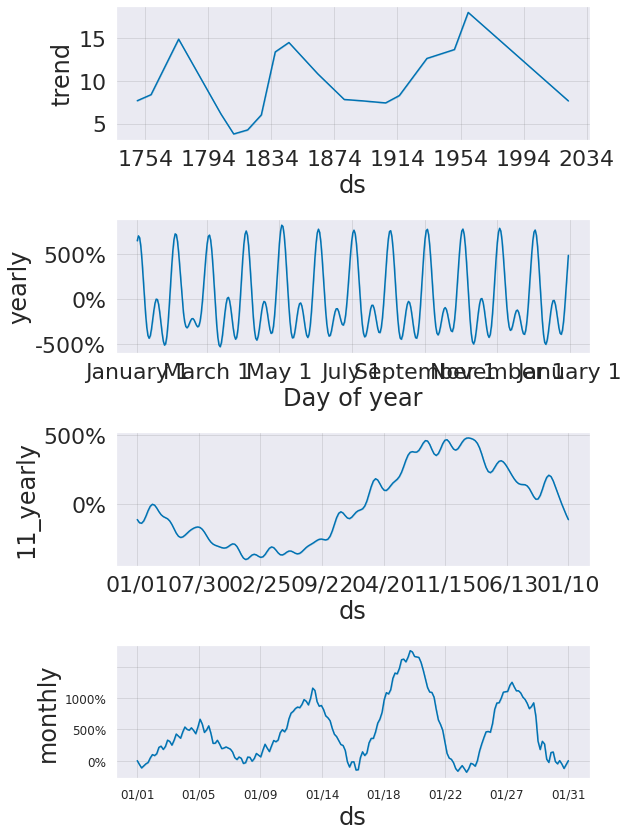

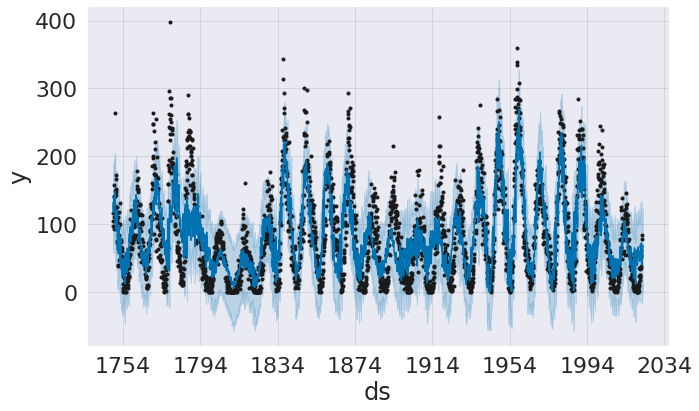

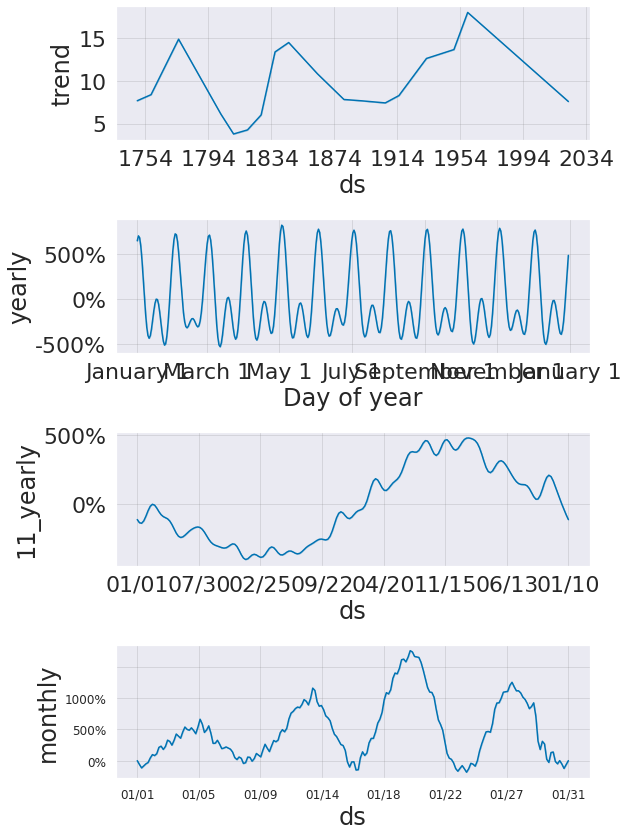

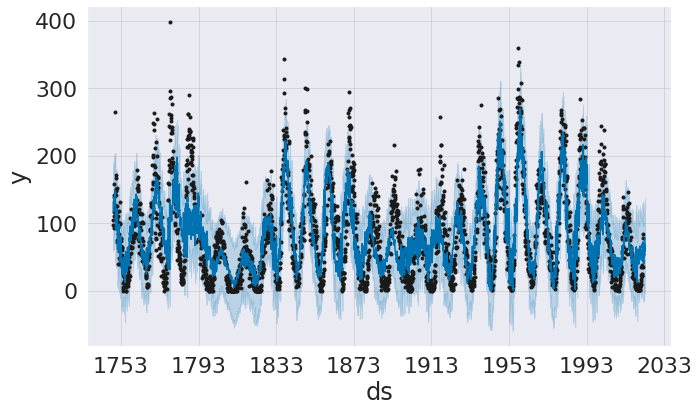

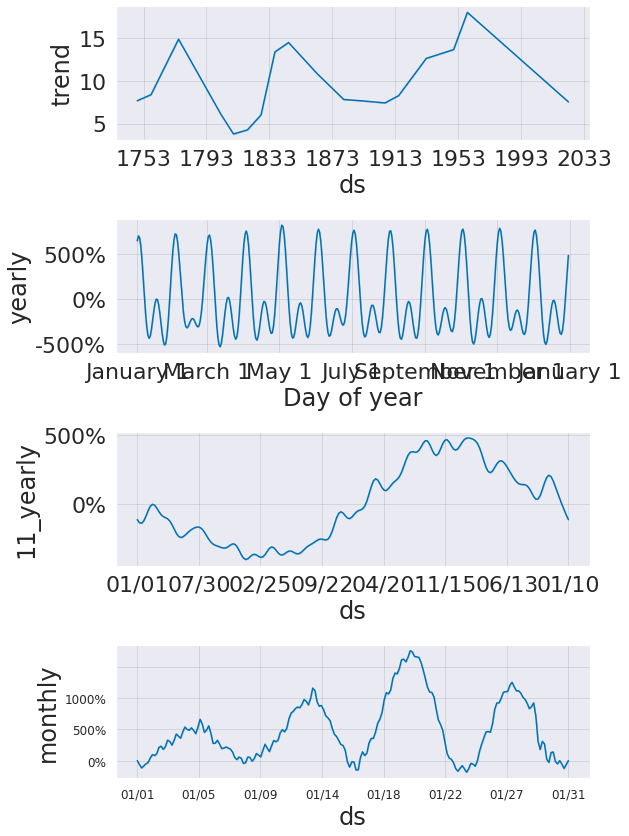

In [144]:
m_fb_prophet_model, m_future_dates_1, m_forcast_1, m_future_dates_2, m_forcast_2, m_future_dates_3, m_forcast_3 = simple_prophet_model(m, df_monthly_model, 1, 6, 9, 'MS', False, True)

Train dates : 1749-01-01 00:00:00 --- 2021-07-01 00:00:00  (n=3271)
Test dates  : 2021-08-01 00:00:00 --- 2022-04-01 00:00:00  (n=9)


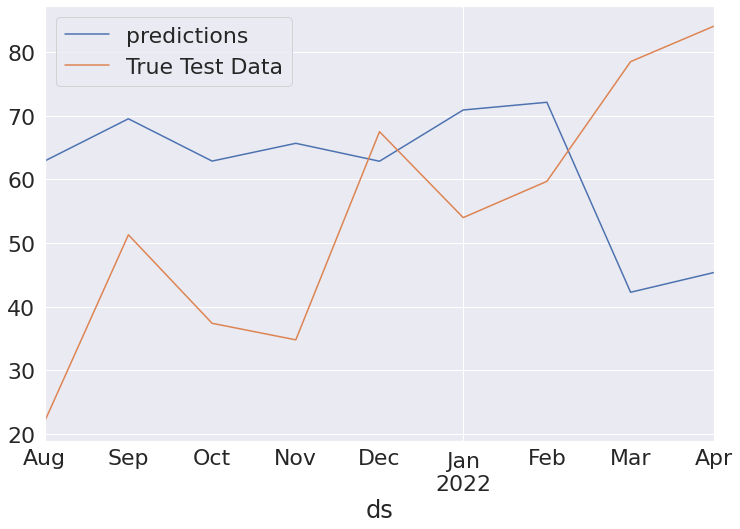

In [150]:
data_train, data_test = split(df_monthly_model, 9)
plot_test_predict(data_test, m_forcast_3[-18:-9])

In [168]:
mean_absolute_error(np.array(data_test["y"]), np.array(m_forcast_3.yhat[-18:-9]))

24.929743205486098

In [167]:
mean_absolute_percentage_error(np.array(data_test["y"]), np.array(m_forcast_3.yhat[-18:-9]))

0.5882169812719303

In [166]:
r2_score(np.array(data_test["y"]), np.array(m_forcast_3.yhat[-18:-9]))

-1.0260166592047866

In [151]:
m_forcast_1

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    1749-01-01  7.680267   78.756511  193.134060     7.680267     7.680267   
1    1749-02-01  7.687117   61.625647  173.917351     7.687117     7.687117   
2    1749-03-01  7.693304   64.412086  175.885274     7.693304     7.693304   
3    1749-04-01  7.700154   79.862999  190.486533     7.700154     7.700154   
4    1749-05-01  7.706783   78.007180  195.502247     7.706783     7.706783   
...         ...       ...         ...         ...          ...          ...   
3276 2022-01-01  7.712741    9.258132  122.322916     7.712741     7.712741   
3277 2022-02-01  7.698902   14.532414  129.185346     7.698902     7.698902   
3278 2022-03-01  7.686402  -17.568596  103.106793     7.686402     7.686402   
3279 2022-04-01  7.672563   -9.812172  106.386054     7.672563     7.672563   
3280 2022-05-01  7.659170  -17.820381   98.630554     7.659170     7.659170   

      11_yearly  11_yearly_lower  11_yearly_upper   monthly  ...  \
0      3.750674         3.750674         3.750674  5.610723  ...   
1      3.549675         3.549675         3.549675  3.509333  ...   
2      3.859887         3.859887         3.859887  3.575272  ...   
3      4.431025         4.431025         4.431025  4.683129  ...   
4      4.700524         4.700524         4.700524  3.575272  ...   
...         ...              ...              ...       ...  ...   
3276  -1.814034        -1.814034        -1.814034  3.783418  ...   
3277  -1.065609        -1.065609        -1.065609  3.090523  ...   
3278  -0.611406        -0.611406        -0.611406 -0.744174  ...   
3279  -0.584456        -0.584456        -0.584456 -0.193003  ...   
3280  -0.857793        -0.857793        -0.857793 -0.744174  ...   

      multiplicative_terms  multiplicative_terms_lower  \
0                16.167483                   16.167483   
1                14.209961                   14.209961   
2                14.538621                   14.538621   
3                16.677860                   16.677860   
4                16.479652                   16.479652   
...                    ...                         ...   
3276              8.193172                    8.193172   
3277              8.367016                    8.367016   
3278              4.499964                    4.499964   
3279              4.915622                    4.915622   
3280              4.157460                    4.157460   

      multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
0                      16.167483  6.806086      6.806086      6.806086   
1                      14.209961  7.150954      7.150954      7.150954   
2                      14.538621  7.103462      7.103462      7.103462   
3                      16.677860  7.563705      7.563705      7.563705   
4                      16.479652  8.203856      8.203856      8.203856   
...                          ...       ...           ...           ...   
3276                    8.193172  6.223788      6.223788      6.223788   
3277                    8.367016  6.342103      6.342103      6.342103   
3278                    4.499964  5.855544      5.855544      5.855544   
3279                    4.915622  5.693081      5.693081      5.693081   
3280                    4.157460  5.759426      5.759426      5.759426   

      additive_terms  additive_terms_lower  additive_terms_upper        yhat  
0                0.0                   0.0                   0.0  131.850853  
1                0.0                   0.0                   0.0  116.920749  
2                0.0                   0.0                   0.0  119.543334  
3                0.0                   0.0                   0.0  136.122237  
4                0.0                   0.0                   0.0  134.711878  
...              ...                   ...                   ...         ...  
3276             0.0                   0.0                   0.0   70.904556  
3277             0.0         

In [152]:
m_forcast_2

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    1749-01-01  7.680267   75.856229  189.511027     7.680267     7.680267   
1    1749-02-01  7.687117   60.831443  174.914815     7.687117     7.687117   
2    1749-03-01  7.693304   57.643779  175.150421     7.693304     7.693304   
3    1749-04-01  7.700154   79.339628  190.766773     7.700154     7.700154   
4    1749-05-01  7.706783   73.409258  190.733222     7.706783     7.706783   
...         ...       ...         ...         ...          ...          ...   
3281 2022-06-01  7.645331  -14.477241   95.985738     7.645331     7.645331   
3282 2022-07-01  7.631939  -18.036132   95.325363     7.631939     7.631939   
3283 2022-08-01  7.618099   -1.986724  107.034833     7.618099     7.618099   
3284 2022-09-01  7.604260   15.554102  123.760922     7.604260     7.604260   
3285 2022-10-01  7.590868   -0.683231  109.302396     7.590868     7.590868   

      11_yearly  11_yearly_lower  11_yearly_upper   monthly  ...  \
0      3.750674         3.750674         3.750674  5.610723  ...   
1      3.549675         3.549675         3.549675  3.509333  ...   
2      3.859887         3.859887         3.859887  3.575272  ...   
3      4.431025         4.431025         4.431025  4.683129  ...   
4      4.700524         4.700524         4.700524  3.575272  ...   
...         ...              ...              ...       ...  ...   
3281  -1.034267        -1.034267        -1.034267 -0.193003  ...   
3282  -0.900859        -0.900859        -0.900859 -0.744174  ...   
3283  -0.615256        -0.615256        -0.615256 -0.193003  ...   
3284  -0.441217        -0.441217        -0.441217  2.126176  ...   
3285  -0.351583        -0.351583        -0.351583 -0.193003  ...   

      multiplicative_terms  multiplicative_terms_lower  \
0                16.167483                   16.167483   
1                14.209961                   14.209961   
2                14.538621                   14.538621   
3                16.677860                   16.677860   
4                16.479652                   16.479652   
...                    ...                         ...   
3281              4.624787                    4.624787   
3282              4.393499                    4.393499   
3283              5.561731                    5.561731   
3284              8.046423                    8.046423   
3285              5.718765                    5.718765   

      multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
0                      16.167483  6.806086      6.806086      6.806086   
1                      14.209961  7.150954      7.150954      7.150954   
2                      14.538621  7.103462      7.103462      7.103462   
3                      16.677860  7.563705      7.563705      7.563705   
4                      16.479652  8.203856      8.203856      8.203856   
...                          ...       ...           ...           ...   
3281                    4.624787  5.852058      5.852058      5.852058   
3282                    4.393499  6.038531      6.038531      6.038531   
3283                    5.561731  6.369989      6.369989      6.369989   
3284                    8.046423  6.361464      6.361464      6.361464   
3285                    5.718765  6.263351      6.263351      6.263351   

      additive_terms  additive_terms_lower  additive_terms_upper        yhat  
0                0.0                   0.0                   0.0  131.850853  
1                0.0                   0.0                   0.0  116.920749  
2                0.0                   0.0                   0.0  119.543334  
3                0.0                   0.0                   0.0  136.122237  
4                0.0                   0.0                   0.0  134.711878  
...              ...                   ...                   ...         ...  
3281             0.0                   0.0                   0.0   43.003360  
3282             0.0         

In [153]:
m_forcast_3

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    1749-01-01  7.680267   72.968868  187.754554     7.680267     7.680267   
1    1749-02-01  7.687117   59.532001  174.052215     7.687117     7.687117   
2    1749-03-01  7.693304   62.034269  180.854371     7.693304     7.693304   
3    1749-04-01  7.700154   78.882022  192.733134     7.700154     7.700154   
4    1749-05-01  7.706783   80.696468  190.157813     7.706783     7.706783   
...         ...       ...         ...         ...          ...          ...   
3284 2022-09-01  7.604260    9.359481  125.649261     7.604260     7.604260   
3285 2022-10-01  7.590868   -5.036902  109.436941     7.590868     7.590868   
3286 2022-11-01  7.577029   11.566874  126.982644     7.577029     7.577029   
3287 2022-12-01  7.563636   -2.527021  117.348963     7.563636     7.563636   
3288 2023-01-01  7.549797   20.323768  136.364790     7.549797     7.549797   

      11_yearly  11_yearly_lower  11_yearly_upper   monthly  ...  \
0      3.750674         3.750674         3.750674  5.610723  ...   
1      3.549675         3.549675         3.549675  3.509333  ...   
2      3.859887         3.859887         3.859887  3.575272  ...   
3      4.431025         4.431025         4.431025  4.683129  ...   
4      4.700524         4.700524         4.700524  3.575272  ...   
...         ...              ...              ...       ...  ...   
3284  -0.441217        -0.441217        -0.441217  2.126176  ...   
3285  -0.351583        -0.351583        -0.351583 -0.193003  ...   
3286  -0.040925        -0.040925        -0.040925  2.126176  ...   
3287   0.626989         0.626989         0.626989 -0.193003  ...   
3288   1.429848         1.429848         1.429848  2.126176  ...   

      multiplicative_terms  multiplicative_terms_lower  \
0                16.167483                   16.167483   
1                14.209961                   14.209961   
2                14.538621                   14.538621   
3                16.677860                   16.677860   
4                16.479652                   16.479652   
...                    ...                         ...   
3284              8.046423                    8.046423   
3285              5.718765                    5.718765   
3286              7.981532                    7.981532   
3287              6.572697                    6.572697   
3288              9.491285                    9.491285   

      multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
0                      16.167483  6.806086      6.806086      6.806086   
1                      14.209961  7.150954      7.150954      7.150954   
2                      14.538621  7.103462      7.103462      7.103462   
3                      16.677860  7.563705      7.563705      7.563705   
4                      16.479652  8.203856      8.203856      8.203856   
...                          ...       ...           ...           ...   
3284                    8.046423  6.361464      6.361464      6.361464   
3285                    5.718765  6.263351      6.263351      6.263351   
3286                    7.981532  5.896282      5.896282      5.896282   
3287                    6.572697  6.138712      6.138712      6.138712   
3288                    9.491285  5.935261      5.935261      5.935261   

      additive_terms  additive_terms_lower  additive_terms_upper        yhat  
0                0.0                   0.0                   0.0  131.850853  
1                0.0                   0.0                   0.0  116.920749  
2                0.0                   0.0                   0.0  119.543334  
3                0.0                   0.0                   0.0  136.122237  
4                0.0                   0.0                   0.0  134.711878  
...              ...                   ...                   ...         ...  
3284             0.0                   0.0                   0.0   68.791359  
3285             0.0         

In [ ]:
# do cv

# Yearly

## Data and brief EDA

Year  Month  Day  Sunspot_number  Standard_deviation  \
Date                                                               
1700-01-01  1700      1    1             8.3                -1.0   
1701-01-01  1701      1    1            18.3                -1.0   
1702-01-01  1702      1    1            26.7                -1.0   
1703-01-01  1703      1    1            38.3                -1.0   
1704-01-01  1704      1    1            60.0                -1.0   

            Number_observations  Provisional_indicator         ds  
Date                                                               
1700-01-01                   -1                      1 1700-01-01  
1701-01-01                   -1                      1 1701-01-01  
1702-01-01                   -1                      1 1702-01-01  
1703-01-01                   -1                      1 1703-01-01  
1704-01-01                   -1                      1 1704-01-01

Year  Month  Day  Sunspot_number  Standard_deviation  \
Date                                                               
2017-01-01  2017      1    1            21.7                 2.5   
2018-01-01  2018      1    1             7.0                 1.1   
2019-01-01  2019      1    1             3.6                 0.5   
2020-01-01  2020      1    1             8.8                 4.1   
2021-01-01  2021      1    1            29.6                 7.9   

            Number_observations  Provisional_indicator         ds  
Date                                                               
2017-01-01                11444                      1 2017-01-01  
2018-01-01                12611                      1 2018-01-01  
2019-01-01                12884                      1 2019-01-01  
2020-01-01                14440                      1 2020-01-01  
2021-01-01                15233                      1 2021-01-01

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322 entries, 1700-01-01 to 2021-01-01
Freq: AS-JAN
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Year                   322 non-null    int32         
 1   Month                  322 non-null    int64         
 2   Day                    322 non-null    int64         
 3   Sunspot_number         322 non-null    float64       
 4   Standard_deviation     322 non-null    float64       
 5   Number_observations    322 non-null    int64         
 6   Provisional_indicator  322 non-null    int64         
 7   ds                     322 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int32(1), int64(4)
memory usage: 21.4 KB


None

Year  Month    Day  Sunspot_number  Standard_deviation  \
count   322.000000  322.0  322.0      322.000000          322.000000   
mean   1860.500000    1.0    1.0       78.365217            4.633540   
std      93.097619    0.0    0.0       62.054638            5.274608   
min    1700.000000    1.0    1.0        0.000000           -1.000000   
25%    1780.250000    1.0    1.0       24.325000           -1.000000   
50%    1860.500000    1.0    1.0       65.150000            4.150000   
75%    1940.750000    1.0    1.0      115.075000            8.850000   
max    2021.000000    1.0    1.0      269.300000           19.100000   

       Number_observations  Provisional_indicator  
count           322.000000                  322.0  
mean           1113.546584                    1.0  
std            2574.732653                    0.0  
min              -1.000000                    1.0  
25%              -1.000000                    1.0  
50%             365.000000                    1.0  
75%             365.000000                    1.0  
max           15233.000000                    1.0

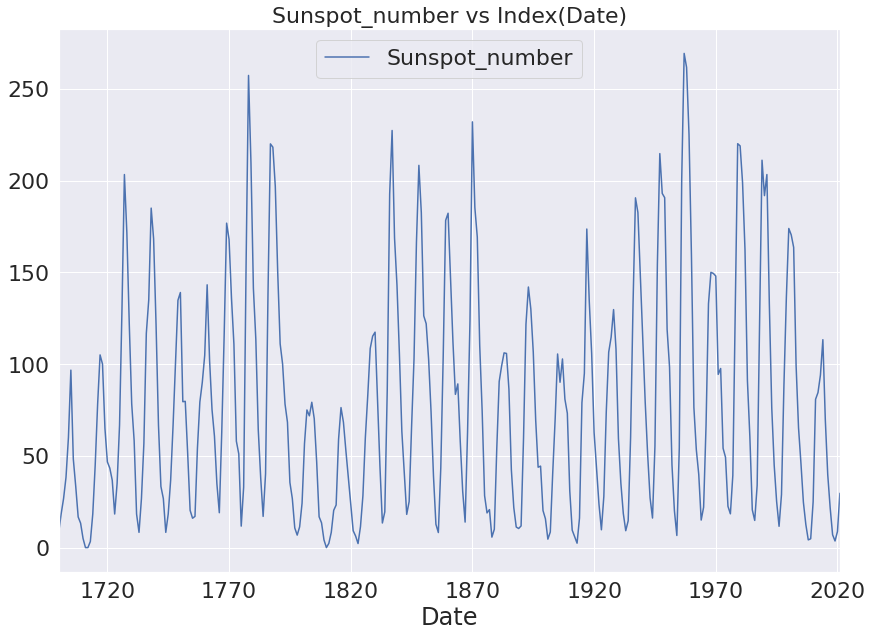

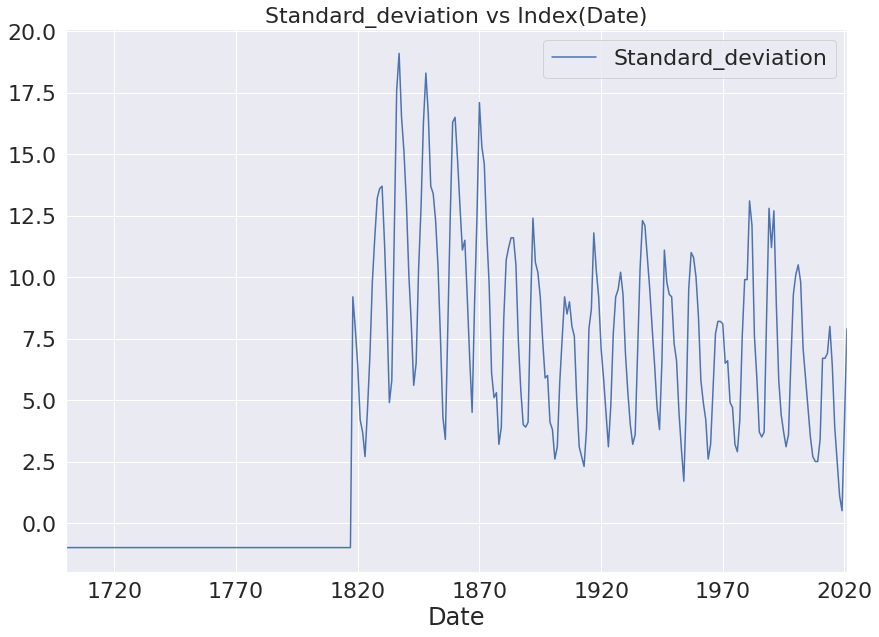

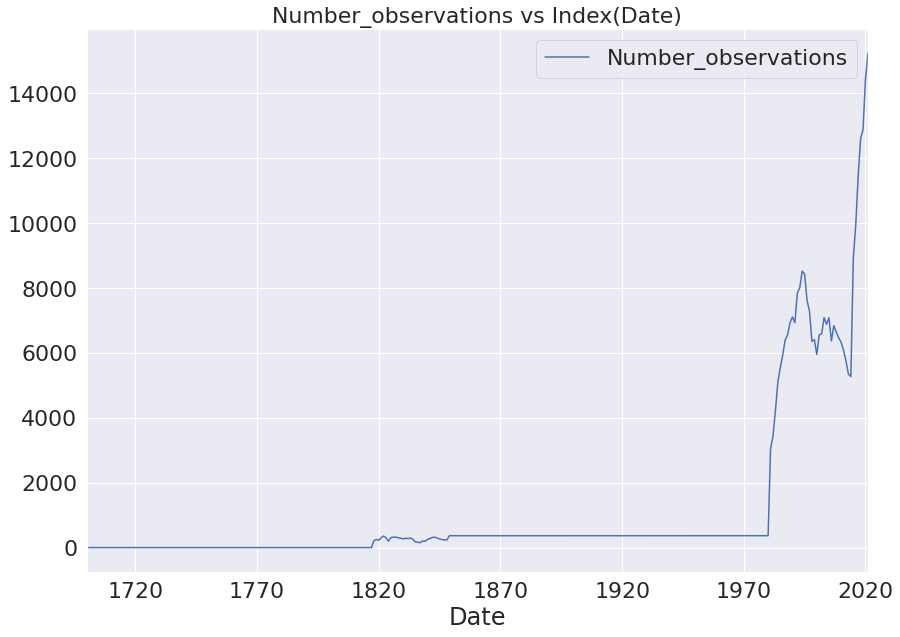

In [238]:
# load in dataset
df_yearly = data_load("yearly", ['Year', 'Sunspot_number', 'Standard_deviation', 
          'Number_observations', 'Provisional_indicator'], 'YS')

# simple & quick EDA
quick_look(df_yearly)

# plot target vs index(date)
simple_plot_bulk(df_yearly, "Sunspot_number", 'Standard_deviation', 'Number_observations')

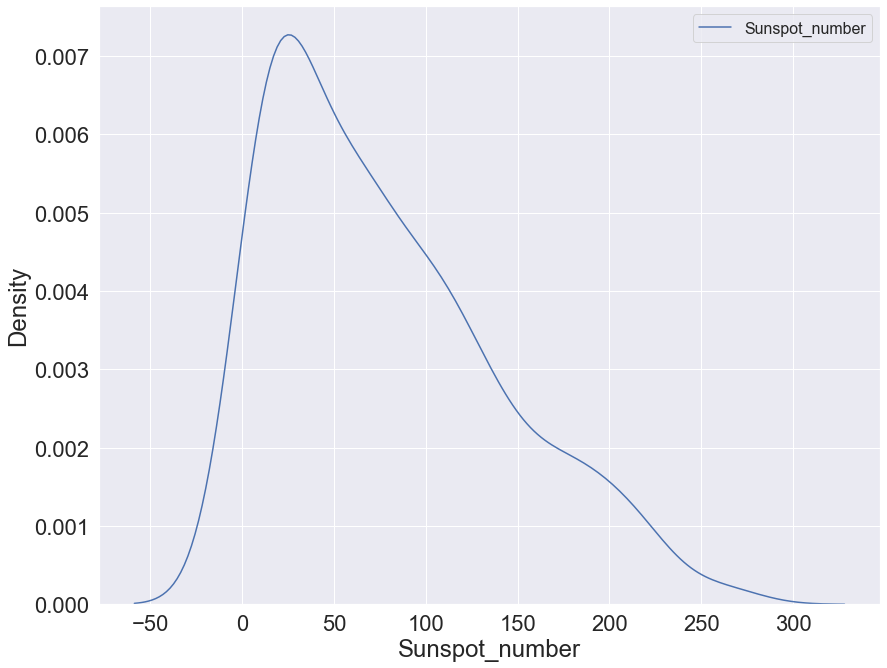

In [239]:
# distribution of values
plot_kde(['Sunspot_number'], df_yearly['Sunspot_number'])

## Model

In [240]:
# extract y
df_yearly_model = extract_df(df_yearly, 'Sunspot_number', 'y', 'ds')

In [241]:
# take a look at the data
display(df_yearly_model.head())
display(df_yearly_model.tail())

ds     y
Date                       
1700-01-01 1700-01-01   8.3
1701-01-01 1701-01-01  18.3
1702-01-01 1702-01-01  26.7
1703-01-01 1703-01-01  38.3
1704-01-01 1704-01-01  60.0

ds     y
Date                       
2017-01-01 2017-01-01  21.7
2018-01-01 2018-01-01   7.0
2019-01-01 2019-01-01   3.6
2020-01-01 2020-01-01   8.8
2021-01-01 2021-01-01  29.6

In [242]:
# median fill
df_yearly_model = handle_missing(df_yearly_model)

Empty DataFrame
Columns: [ds, y]
Index: []

Empty DataFrame
Columns: [ds, y]
Index: []

In [243]:
# confirm
df_yearly_model

ds     y
Date                       
1700-01-01 1700-01-01   8.3
1701-01-01 1701-01-01  18.3
1702-01-01 1702-01-01  26.7
1703-01-01 1703-01-01  38.3
1704-01-01 1704-01-01  60.0
...               ...   ...
2017-01-01 2017-01-01  21.7
2018-01-01 2018-01-01   7.0
2019-01-01 2019-01-01   3.6
2020-01-01 2020-01-01   8.8
2021-01-01 2021-01-01  29.6

[322 rows x 2 columns]

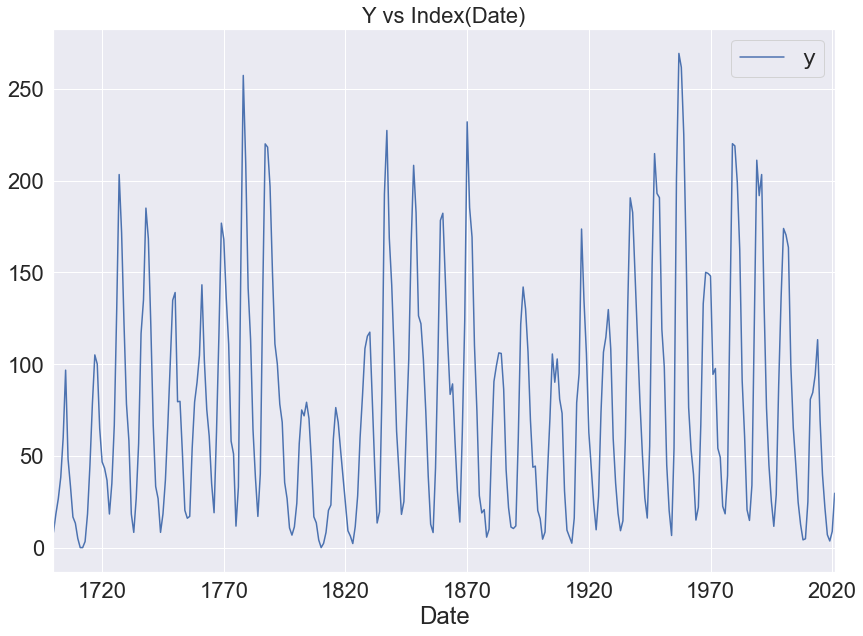

In [244]:
# plot target vs index(date)
simple_plot_bulk(df_yearly_model, 'y')

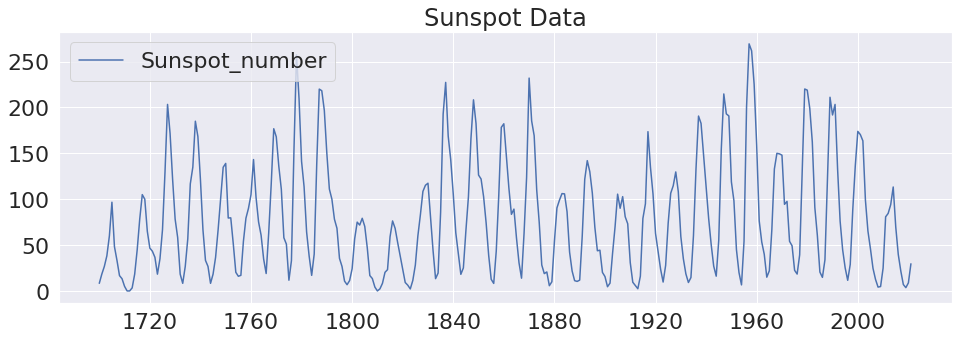

Results of Dickey-Fuller Test:
Test Statistic                  -3.106612
p-value                          0.026068
#Lags Used                       8.000000
Number of Observations Used    313.000000
Critical Value (1%)             -3.451416
Critical Value (5%)             -2.870819
Critical Value (10%)            -2.571714
dtype: float64
Conclusion
0.026067722399238862
Reject the null hypothesis: Stationary


In [245]:
# A key point to remember here is: Since the null hypothesis assumes the presence of unit root, that is α=1, 
# the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. 
# Thereby, inferring that the series is stationary

# The ADF tests gives the following results – test statistic, p-value and the critical value at 1%, 5% , and 
# 10% confidence intervals.
adf_test_show(df_yearly_model, 'y')

In [246]:
# If Test statistic > Critical Value and p-value > 0.05 – Fail to Reject Null Hypothesis(HO) i.e., 
# time series does not have a unit root, meaning it is trend stationary.
kpss_test(df_yearly_model['y'])

Results of KPSS Test:
Test Statistic           0.23219
p-value                  0.10000
#Lags Used               7.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64
Conclusion
0.1
DO NOT Reject the null hypothesis: Stationary


C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# FBProphet

In [250]:
df_yearly_model = df_yearly_model[100:]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


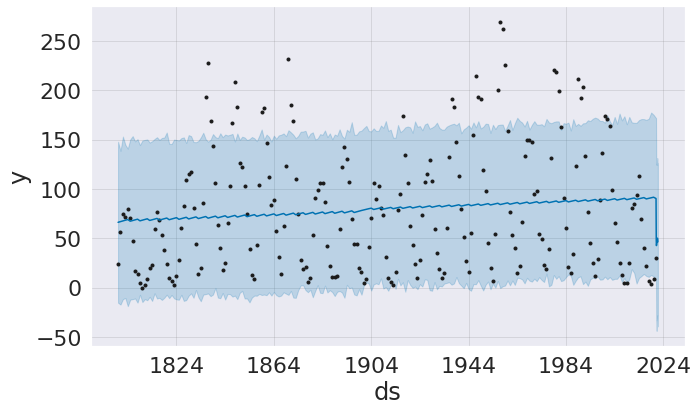

In [251]:
# Python
y_m_m_1 = Prophet()
y_m_m_1.fit(df_yearly_model)
future = y_m_m_1.make_future_dataframe(9, freq='MS')
forecast = y_m_m_1.predict(future)
fig = y_m_m_1.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


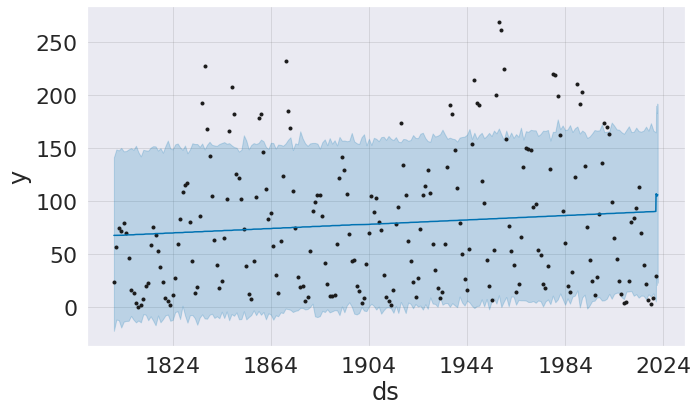

In [252]:
# Python
y_m_m_1 = Prophet(seasonality_mode='multiplicative')
y_m_m_1.fit(df_yearly_model)
future = y_m_m_1.make_future_dataframe(9, freq='MS')
forecast = y_m_m_1.predict(future)
fig = y_m_m_1.plot(forecast)

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
218 2018-01-01  293.041811  -42.872234   30.993260   293.041811   293.041811   
219 2019-01-01  294.294069  -46.275275   33.858983   294.294069   294.294069   
220 2020-01-01  295.546328  -24.021770   55.023074   295.546328   295.546328   
221 2021-01-01  296.802017   -9.377513   69.865916   296.802017   296.802017   
222 2021-12-31  298.050844    2.005792   82.010368   298.050844   298.050844   

     11_yearly  11_yearly_lower  11_yearly_upper  multiplicative_terms  \
218   0.472839         0.472839         0.472839             -1.025876   
219   0.467427         0.467427         0.467427             -1.022796   
220   0.523549         0.523549         0.523549             -0.951948   
221   0.596289         0.596289         0.596289             -0.904633   
222   0.574787         0.574787         0.574787             -0.853015   

     multiplicative_terms_lower  multiplicative_terms_upper    yearly  \
218                   -1.025876                   -1.025876 -1.498716   
219                   -1.022796                   -1.022796 -1.490222   
220                   -0.951948                   -0.951948 -1.475497   
221                   -0.904633                   -0.904633 -1.500922   
222                   -0.853015                   -0.853015 -1.427802   

     yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
218     -1.498716     -1.498716             0.0                   0.0   
219     -1.490222     -1.490222             0.0                   0.0   
220     -1.475497     -1.475497             0.0                   0.0   
221     -1.500922     -1.500922             0.0                   0.0   
222     -1.427802     -1.427802             0.0                   0.0   

     additive_terms_upper       yhat  
218                   0.0  -7.582891  
219                   0.0  -6.708648  
220                   0.0  14.201545  
221                   0.0  28.305249  
222                   0.0  43.808896

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarnin

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
227 2026-12-31  304.315566  -45.130584   33.892743   304.315566   304.315566   
228 2027-12-31  305.567825  -29.401218   50.137702   305.567825   305.567825   
229 2028-12-31  306.823514  -57.646412   19.552771   306.823514   306.823514   
230 2029-12-31  308.075772  -46.920881   29.578128   308.075772   308.075772   
231 2030-12-31  309.328030  -28.717218   52.687273   309.328030   309.328030   

     11_yearly  11_yearly_lower  11_yearly_upper  multiplicative_terms  \
227   0.378173         0.378173         0.378173             -1.016994   
228   0.387177         0.387177         0.387177             -0.969790   
229   0.398696         0.398696         0.398696             -1.055946   
230   0.398201         0.398201         0.398201             -1.029601   
231   0.431458         0.431458         0.431458             -0.963708   

     multiplicative_terms_lower  multiplicative_terms_upper    yearly  \
227                   -1.016994                   -1.016994 -1.395167   
228                   -0.969790                   -0.969790 -1.356967   
229                   -1.055946                   -1.055946 -1.454642   
230                   -1.029601                   -1.029601 -1.427802   
231                   -0.963708                   -0.963708 -1.395167   

     yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
227     -1.395167     -1.395167             0.0                   0.0   
228     -1.356967     -1.356967             0.0                   0.0   
229     -1.454642     -1.454642             0.0                   0.0   
230     -1.427802     -1.427802             0.0                   0.0   
231     -1.395167     -1.395167             0.0                   0.0   

     additive_terms_upper       yhat  
227                   0.0  -5.171436  
228                   0.0   9.231058  
229                   0.0 -17.165670  
230                   0.0  -9.119282  
231                   0.0  11.226026

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarnin

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
237 2036-12-31  316.848442 -191.747579 -114.424675   316.848441   316.848442   
238 2037-12-31  318.100700 -112.282359  -30.080302   318.100700   318.100700   
239 2038-12-31  319.352958  -80.213256    2.779838   319.352958   319.352959   
240 2039-12-31  320.605216  -55.183305   26.777819   320.605216   320.605217   
241 2040-12-31  321.860906  -80.077528   -5.410814   321.860905   321.860906   

     11_yearly  11_yearly_lower  11_yearly_upper  multiplicative_terms  \
237  -0.025508        -0.025508        -0.025508             -1.480150   
238   0.204442         0.204442         0.204442             -1.223360   
239   0.267632         0.267632         0.267632             -1.127535   
240   0.313737         0.313737         0.313737             -1.043230   
241   0.324085         0.324085         0.324085             -1.130557   

     multiplicative_terms_lower  multiplicative_terms_upper    yearly  \
237                   -1.480150                   -1.480150 -1.454642   
238                   -1.223360                   -1.223360 -1.427802   
239                   -1.127535                   -1.127535 -1.395167   
240                   -1.043230                   -1.043230 -1.356967   
241                   -1.130557                   -1.130557 -1.454642   

     yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
237     -1.454642     -1.454642             0.0                   0.0   
238     -1.427802     -1.427802             0.0                   0.0   
239     -1.395167     -1.395167             0.0                   0.0   
240     -1.356967     -1.356967             0.0                   0.0   
241     -1.454642     -1.454642             0.0                   0.0   

     additive_terms_upper        yhat  
237                   0.0 -152.134644  
238                   0.0  -71.050916  
239                   0.0  -40.728622  
240                   0.0  -13.859753  
241                   0.0  -42.021297

C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\akame\anaconda3\envs\env_full\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


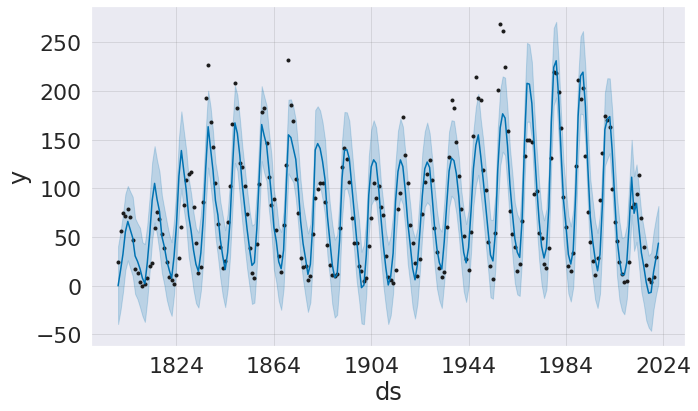

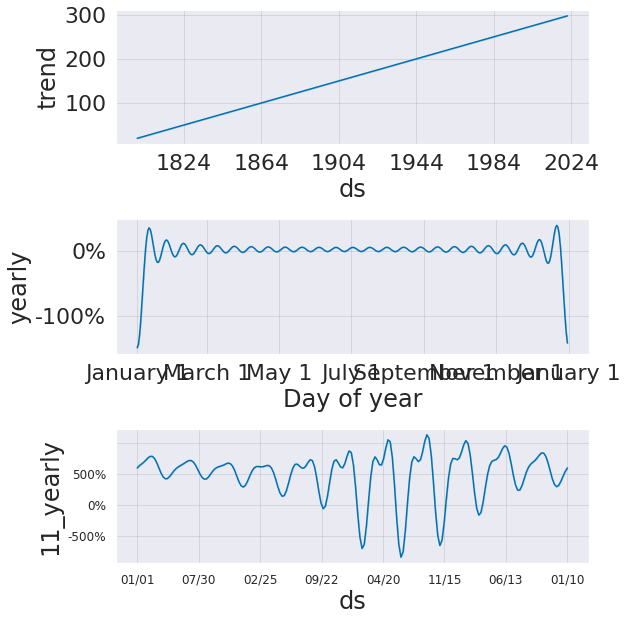

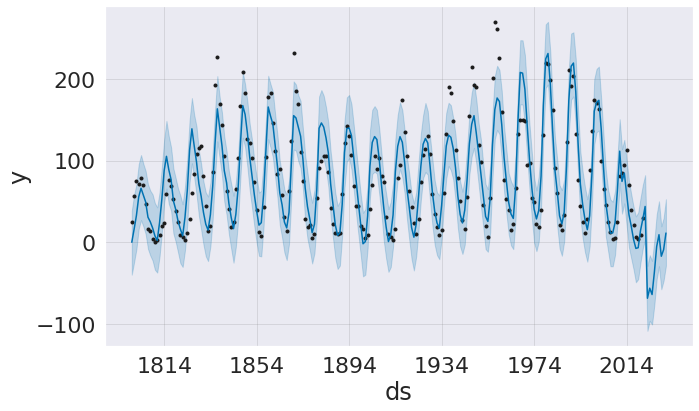

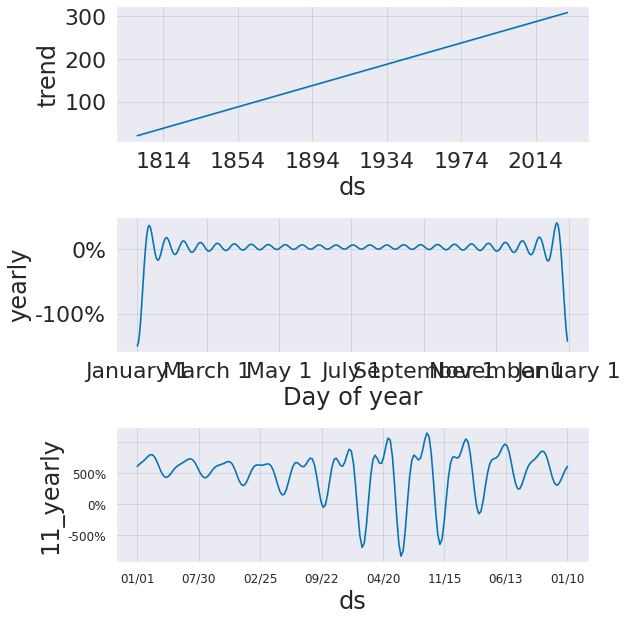

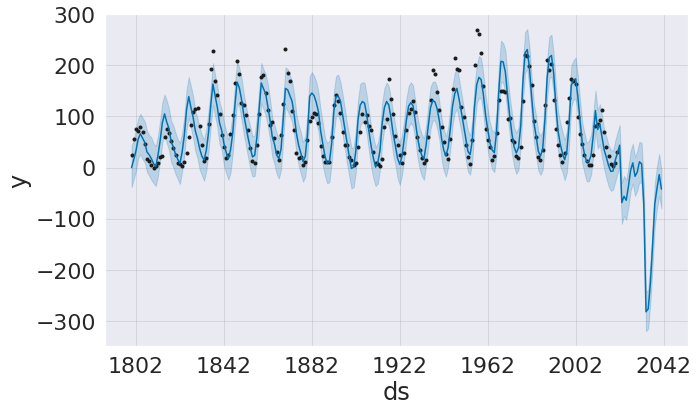

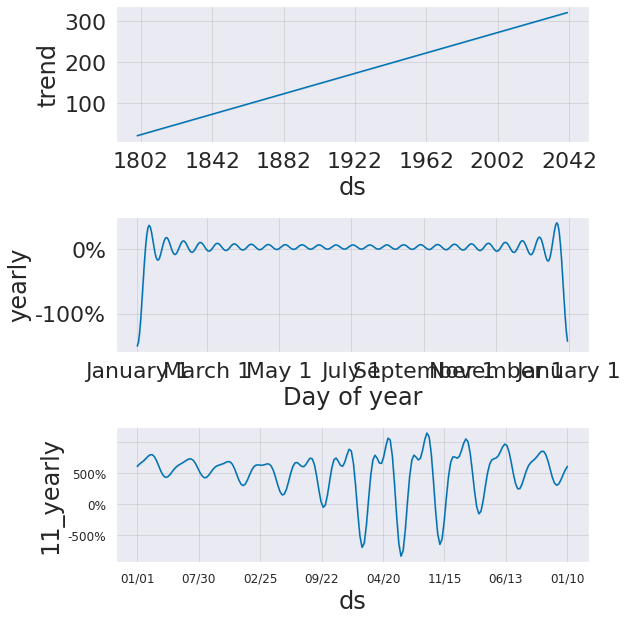

In [253]:
y_fb_prophet_model, y_future_dates_1, y_forcast_1, y_future_dates_2, y_forcast_2, y_future_dates_3, y_forcast_3 = simple_prophet_model(m, df_yearly_model, 1, 10, 20, 'y', False, False)

Train dates : 1800-01-01 00:00:00 --- 2011-01-01 00:00:00  (n=212)
Test dates  : 2012-01-01 00:00:00 --- 2021-01-01 00:00:00  (n=10)


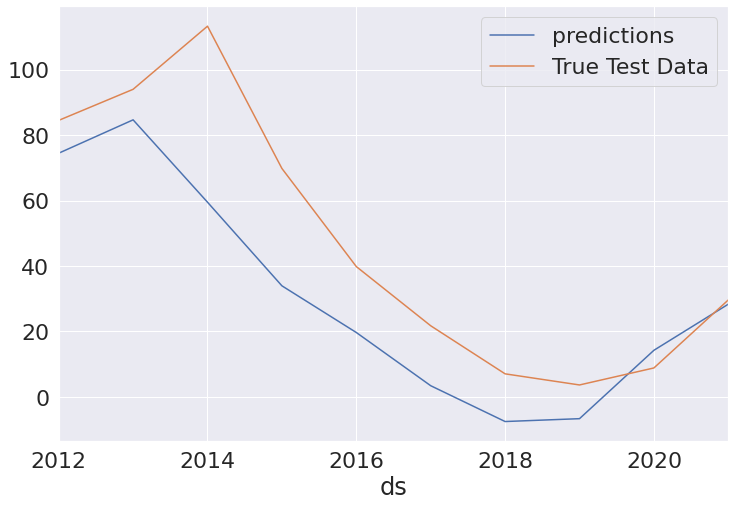

In [257]:
data_train, data_test = split(df_yearly_model, 10)
plot_test_predict(data_test, y_forcast_2[-20:-10])

In [258]:
mean_absolute_error(np.array(data_test["y"]), np.array(y_forcast_2.yhat[-20:-10]))

17.915335233607166

In [259]:
mean_absolute_percentage_error(np.array(data_test["y"]), np.array(y_forcast_2.yhat[-20:-10]))

0.816275044245692

In [260]:
r2_score(np.array(data_test["y"]), np.array(y_forcast_2.yhat[-20:-10]))

0.6223170586532639

Train dates : 1800-01-01 00:00:00 --- 2001-01-01 00:00:00  (n=202)
Test dates  : 2002-01-01 00:00:00 --- 2021-01-01 00:00:00  (n=20)


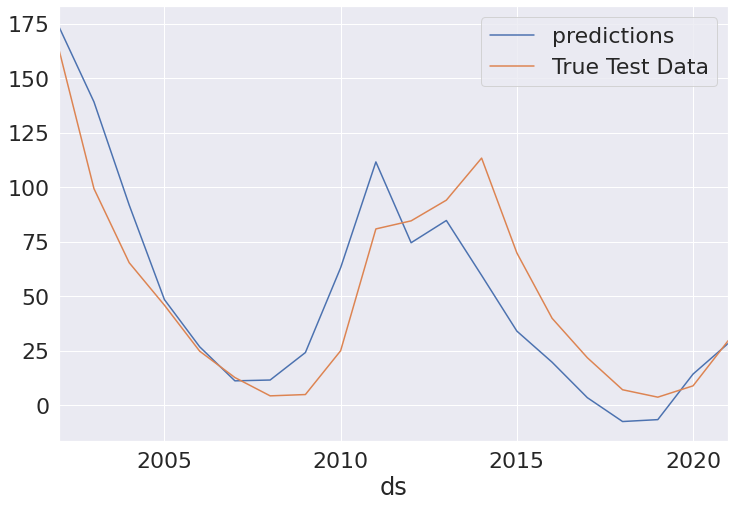

In [261]:
data_train, data_test = split(df_yearly_model, 20)
plot_test_predict(data_test, y_forcast_3[-40:-20])

In [262]:
mean_absolute_error(np.array(data_test["y"]), np.array(y_forcast_3.yhat[-40:-20]))

17.856170474371975

In [263]:
mean_absolute_percentage_error(np.array(data_test["y"]), np.array(y_forcast_3.yhat[-40:-20]))

0.847222161211042

In [264]:
r2_score(np.array(data_test["y"]), np.array(y_forcast_3.yhat[-40:-20]))

0.7179274229751886

In [265]:
initial = df_yearly_model.shape[0] / 2

period = initial / 4

horizon = initial / 2

In [ ]:
prophet_y, forcast_y, cv_results_y = model_with_cv(df_daily_model, 'linear', 39, 30, 30, 'YS', 20, initial, period, horizon, 'days', monthly=False, daily=False)